# **distillgpt2_finalizedwith_FAISS.**

In [ ]:
# Cell 0: (Re)install compatible versions
!pip uninstall -y transformers sentence-transformers huggingface-hub
# Install huggingface_hub first with a specific version known to work
!pip install huggingface_hub==0.12.0
!pip install transformers==4.29.0 sentence-transformers==2.2.2

# Cell 1: Install necessary packages
!pip install faiss-cpu
!pip install datasets
!pip install --upgrade numpy datasets

# Ensure sentence-transformers is installed before importing
!pip install sentence-transformers==2.2.2


Found existing installation: huggingface-hub 0.32.4
Uninstalling huggingface-hub-0.32.4:
  Successfully uninstalled huggingface-hub-0.32.4
  Using cached huggingface_hub-0.12.0-py3-none-any.whl.metadata (7.8 kB)
Using cached huggingface_hub-0.12.0-py3-none-any.whl (190 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires transformers, which is not installed.
datasets 3.6.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.12.0 which is incompatible.
diffusers 0.33.1 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.12.0 which is incompatible.
gradio-client 1.10.1 requires huggingface-hub>=0.19.3, but you have huggingface-hub 0.12.0 which is incompatible.
gradio 5.31.0 requires huggingface-hub>=0.28.1, but you have huggingface-hub 0.12.0 which is incompatible.
peft 0.15.2 requires huggingface_hub>=0.25.0, but you

  Using cached transformers-4.29.0-py3-none-any.whl.metadata (111 kB)
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
Using cached transformers-4.29.0-py3-none-any.whl (7.1 MB)
ERROR: Operation cancelled by user
^C
^C
^C
^C


In [2]:
# Cell 1: Install necessary packages
!pip install faiss-cpu
!pip install datasets
!pip install --upgrade numpy datasets


  Using cached huggingface_hub-0.32.4-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.32.4-py3-none-any.whl (512 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires transformers, which is not installed.


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 62.8 MB/s eta 0:00:00


In [3]:
# Cell 2: Imports (same as your original notebook)
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import faiss
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset, load_dataset
import torch


In [7]:
# Cell 0: (Re)install compatible versions
!pip uninstall -y transformers sentence-transformers huggingface-hub
# Install huggingface_hub first with a specific version known to work
!pip install huggingface_hub==0.12.0
!pip install transformers==4.29.0 sentence-transformers==2.2.2

Found existing installation: transformers 4.29.0
Uninstalling transformers-4.29.0:
  Successfully uninstalled transformers-4.29.0
Found existing installation: sentence-transformers 2.2.2
Uninstalling sentence-transformers-2.2.2:
  Successfully uninstalled sentence-transformers-2.2.2
Found existing installation: huggingface-hub 0.32.4
Uninstalling huggingface-hub-0.32.4:
  Successfully uninstalled huggingface-hub-0.32.4
  Using cached huggingface_hub-0.12.0-py3-none-any.whl.metadata (7.8 kB)
Using cached huggingface_hub-0.12.0-py3-none-any.whl (190 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires transformers, which is not installed.
datasets 3.6.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.12.0 which is incompatible.
diffusers 0.33.1 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.12.0 which is inco

  Using cached transformers-4.29.0-py3-none-any.whl.metadata (111 kB)
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
Using cached transformers-4.29.0-py3-none-any.whl (7.1 MB)
ERROR: Operation cancelled by user
^C


In [1]:
from sentence_transformers import SentenceTransformer

ModuleNotFoundError: No module named 'sentence_transformers'

In [4]:
# Cell 3: Load and preprocess data
url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)

def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    # Temporal features
    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(
        df['Hour of the Day'],
        bins=[0, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening']
    )
    df['is_weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    # Seasonal features
    season_dict = {
        'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
        'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
        'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
        'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
    }
    df['Season'] = df['Month'].map(season_dict)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    # Energy features
    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)
    consumption_threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = df['Energy Consumption (kWh)'].apply(
        lambda x: 1 if x > consumption_threshold else 0
    )

    # Feature scaling
    features_to_scale = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

    # Efficiency metrics
    for appliance in appliances:
        df[f'{appliance}_efficiency_ratio'] = df[appliance] / (df['Energy Consumption (kWh)'] + 1e-6)

    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)
    df['active_appliances'] = df[appliances].sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    return df

data = preprocess_data(data)


In [5]:
# Cell 4: Prepare data for LSTM (if you still need LSTM training; not strictly required for fine-tuning)
def prepare_lstm_data(df):
    cat_cols = ['Season', 'part_of_day', 'Day of the Week', 'Offloading Decision']
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    X = df_encoded.drop('is_high_consumption', axis=1)
    y = df_encoded['is_high_consumption']

    month_mapping = {month: i+1 for i, month in enumerate([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])}
    X['Month'] = X['Month'].map(month_mapping)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_lstm_data(data)

def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(X_val.values, y_val.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, TIME_STEPS)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).shuffle(1000).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_seq, y_val_seq)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(32)

lstm_model = create_lstm_model((TIME_STEPS, X_train_seq.shape[2]))
lstm_model.fit(train_ds, validation_data=val_ds, epochs=20)
lstm_model.evaluate(test_ds)


Epoch 1/20
918/918 [==============================] - 15s 14ms/step - loss: 0.1970 - mae: 0.3728 - val_loss: 0.1914 - val_mae: 0.3611
Epoch 2/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1884 - mae: 0.3716 - val_loss: 0.1913 - val_mae: 0.3600
Epoch 3/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1876 - mae: 0.3718 - val_loss: 0.1912 - val_mae: 0.3640
Epoch 4/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1872 - mae: 0.3720 - val_loss: 0.1912 - val_mae: 0.3615
Epoch 5/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1870 - mae: 0.3724 - val_loss: 0.1907 - val_mae: 0.3648
Epoch 6/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1870 - mae: 0.3728 - val_loss: 0.1902 - val_mae: 0.3682
Epoch 7/20
918/918 [==============================] - 12s 13ms/step - loss: 0.1869 - mae: 0.3725 - val_loss: 0.1899 - val_mae: 0.3719
Epoch 8/20
918/918 [==============================] - 12s 13ms

[0.19099144637584686, 0.3559432923793793]

In [6]:
# Cell 5: Generate embeddings and build FAISS index
def generate_text_description(row):
    appliances_status = ", ".join(
        f"{appliance}: {'ON' if row[appliance] > 0 else 'OFF'}"
        for appliance in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    )
    return (
        f"At {row['Hour of the Day']}:00 during {row['Season']} {row['part_of_day']}, "
        f"appliances: {appliances_status}. Energy: {row['Energy Consumption (kWh)']:.2f} kWh"
    )

embedding_model = SentenceTransformer(
    'all-MiniLM-L6-v2',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
data['text_description'] = data.apply(generate_text_description, axis=1)

embeddings = embedding_model.encode(
    data['text_description'].tolist(),
    show_progress_bar=True
)

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1531 [00:00<?, ?it/s]

In [7]:
# Cell 6: Define helper to build a “prompt” string from FAISS-similar rows
def generate_prompt_with_embeddings(similar_data, distances):
    prompt = "Based on these similar past records:\n"
    for idx, (i, row) in enumerate(similar_data.iterrows(), start=1):
        prompt += f"{idx}.\n"
        prompt += f"- Hour: {row['Hour of the Day']}, Part of Day: {row['part_of_day']}, Month: {row['Month']}, Day of Week: {row['Day of the Week']}\n"
        prompt += f"- Season: {row['Season']}, Peak Hour: {row['is_peak_hour']}, Weekend: {row['is_weekend']}\n"
        prompt += f"- Active Appliances: {row['active_appliances']}, Power Factor: {row['power_factor']:.2f}\n"
        prompt += f"- Total Consumption: {row['Energy Consumption (kWh)']:.2f} kWh, High Consumption: {row['is_high_consumption']}\n"
        prompt += (
            f"- Appliance Efficiency Ratios → TV: {row['Television_efficiency_ratio']:.2f}, "
            f"Dryer: {row['Dryer_efficiency_ratio']:.2f}, "
            f"Oven: {row['Oven_efficiency_ratio']:.2f}, "
            f"Fridge: {row['Refrigerator_efficiency_ratio']:.2f}, "
            f"Microwave: {row['Microwave_efficiency_ratio']:.2f}\n"
        )
        prompt += f"- Energy Per Active Appliance: {row['energy_per_active_appliance']:.2f} kWh\n"
        prompt += f"- Offloading Decision Taken: {row['Offloading Decision']}\n\n"
    prompt += "Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:\n"
    return prompt


In [8]:
# Cell 7: Build prompt_texts + completion_texts with 15 examples

prompt_texts = [
    # ─── Existing Example 1 (index 10) ─────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 10, Part of Day: morning, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 0.88
- Total Consumption: 0.45 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: No

2.
- Hour: 11, Part of Day: morning, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 3, Power Factor: 0.90
- Total Consumption: 0.55 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.20, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 12, Part of Day: afternoon, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 4, Power Factor: 0.92
- Total Consumption: 0.80 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.30, Fridge: 0.20, Microwave: 0.20
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── Existing Example 2 (index 50) ─────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 18, Part of Day: evening, Month: 6, Day of Week: Friday
- Season: Summer, Peak Hour: 1, Weekend: 0
- Active Appliances: 3, Power Factor: 0.85
- Total Consumption: 0.65 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.15, Dryer: 0.00, Oven: 0.15, Fridge: 0.30, Microwave: 0.05
- Energy Per Active Appliance: 0.22 kWh
- Offloading Decision Taken: No

2.
- Hour: 19, Part of Day: evening, Month: 6, Day of Week: Friday
- Season: Summer, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.90
- Total Consumption: 0.75 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.15, Dryer: 0.10, Oven: 0.20, Fridge: 0.20, Microwave: 0.10
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 20, Part of Day: evening, Month: 6, Day of Week: Friday
- Season: Summer, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.88
- Total Consumption: 0.50 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.20, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.25 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── Existing Example 3 (index 100) ────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 14, Part of Day: afternoon, Month: 7, Day of Week: Wednesday
- Season: Summer, Peak Hour: 1, Weekend: 0
- Active Appliances: 3, Power Factor: 0.93
- Total Consumption: 0.70 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.35, Fridge: 0.20, Microwave: 0.05
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 15, Part of Day: afternoon, Month: 7, Day of Week: Wednesday
- Season: Summer, Peak Hour: 0, Weekend: 0
- Active Appliances: 4, Power Factor: 0.91
- Total Consumption: 0.85 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.30, Fridge: 0.25, Microwave: 0.10
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 16, Part of Day: afternoon, Month: 7, Day of Week: Wednesday
- Season: Summer, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.89
- Total Consumption: 0.55 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.35, Microwave: 0.10
- Energy Per Active Appliance: 0.28 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── Existing Example 4 (index 150) ────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 8, Part of Day: morning, Month: 12, Day of Week: Saturday
- Season: Winter, Peak Hour: 0, Weekend: 1
- Active Appliances: 4, Power Factor: 0.94
- Total Consumption: 0.60 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.10, Oven: 0.20, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.15 kWh
- Offloading Decision Taken: No

2.
- Hour: 9, Part of Day: morning, Month: 12, Day of Week: Saturday
- Season: Winter, Peak Hour: 1, Weekend: 1
- Active Appliances: 5, Power Factor: 0.92
- Total Consumption: 0.90 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.10, Oven: 0.25, Fridge: 0.30, Microwave: 0.10
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 10, Part of Day: morning, Month: 12, Day of Week: Saturday
- Season: Winter, Peak Hour: 0, Weekend: 1
- Active Appliances: 3, Power Factor: 0.90
- Total Consumption: 0.55 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.00, Oven: 0.20, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── Existing Example 5 (index 200) ────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 21, Part of Day: evening, Month: 9, Day of Week: Sunday
- Season: Fall, Peak Hour: 1, Weekend: 1
- Active Appliances: 4, Power Factor: 0.87
- Total Consumption: 0.75 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.10, Fridge: 0.30, Microwave: 0.05
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 22, Part of Day: evening, Month: 9, Day of Week: Sunday
- Season: Fall, Peak Hour: 0, Weekend: 1
- Active Appliances: 2, Power Factor: 0.89
- Total Consumption: 0.40 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: No

3.
- Hour: 23, Part of Day: night, Month: 9, Day of Week: Sunday
- Season: Fall, Peak Hour: 0, Weekend: 1
- Active Appliances: 1, Power Factor: 0.92
- Total Consumption: 0.30 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.30 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 6 ─────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 7, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 3, Power Factor: 0.91
- Total Consumption: 0.58 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.20, Fridge: 0.20, Microwave: 0.05
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: No

2.
- Hour: 8, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.89
- Total Consumption: 0.80 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.30, Fridge: 0.20, Microwave: 0.10
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 9, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.93
- Total Consumption: 0.45 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 7 ─────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 13, Part of Day: afternoon, Month: 8, Day of Week: Wednesday
- Season: Summer, Peak Hour: 1, Weekend: 0
- Active Appliances: 5, Power Factor: 0.88
- Total Consumption: 0.95 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.30, Fridge: 0.25, Microwave: 0.20
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 14, Part of Day: afternoon, Month: 8, Day of Week: Wednesday
- Season: Summer, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.90
- Total Consumption: 0.65 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.25, Fridge: 0.20, Microwave: 0.10
- Energy Per Active Appliance: 0.22 kWh
- Offloading Decision Taken: No

3.
- Hour: 15, Part of Day: afternoon, Month: 8, Day of Week: Wednesday
- Season: Summer, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.92
- Total Consumption: 0.48 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.24 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 8 ─────────────────────────────────────────────────────────
    """ Based on these similar past records:
1.
- Hour: 17, Part of Day: evening, Month: 3, Day of Week: Sunday
- Season: Spring, Peak Hour: 1, Weekend: 1
- Active Appliances: 4, Power Factor: 0.87
- Total Consumption: 0.78 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.15, Dryer: 0.00, Oven: 0.30, Fridge: 0.20, Microwave: 0.10
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 18, Part of Day: evening, Month: 3, Day of Week: Sunday
- Season: Spring, Peak Hour: 0, Weekend: 1
- Active Appliances: 3, Power Factor: 0.89
- Total Consumption: 0.60 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.15, Dryer: 0.00, Oven: 0.20, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: No

3.
- Hour: 19, Part of Day: evening, Month: 3, Day of Week: Sunday
- Season: Spring, Peak Hour: 0, Weekend: 1
- Active Appliances: 2, Power Factor: 0.91
- Total Consumption: 0.42 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.15, Dryer: 0.00, Oven: 0.00, Fridge: 0.25, Microwave: 0.00
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 9 ─────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 12, Part of Day: afternoon, Month: 11, Day of Week: Thursday
- Season: Fall, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.90
- Total Consumption: 0.82 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.15, Oven: 0.30, Fridge: 0.20, Microwave: 0.05
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 13, Part of Day: afternoon, Month: 11, Day of Week: Thursday
- Season: Fall, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.91
- Total Consumption: 0.60 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.25, Fridge: 0.20, Microwave: 0.05
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: No

3.
- Hour: 14, Part of Day: afternoon, Month: 11, Day of Week: Thursday
- Season: Fall, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.92
- Total Consumption: 0.50 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.25 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 10 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 16, Part of Day: afternoon, Month: 2, Day of Week: Tuesday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 5, Power Factor: 0.85
- Total Consumption: 0.98 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.25, Oven: 0.30, Fridge: 0.25, Microwave: 0.10
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 17, Part of Day: evening, Month: 2, Day of Week: Tuesday
- Season: Winter, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.88
- Total Consumption: 0.65 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.15, Oven: 0.20, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.22 kWh
- Offloading Decision Taken: No

3.
- Hour: 18, Part of Day: evening, Month: 2, Day of Week: Tuesday
- Season: Winter, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.90
- Total Consumption: 0.50 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.25 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 11 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 9, Part of Day: morning, Month: 10, Day of Week: Friday
- Season: Fall, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.92
- Total Consumption: 0.55 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.00, Oven: 0.10, Fridge: 0.30, Microwave: 0.10
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: No

2.
- Hour: 10, Part of Day: morning, Month: 10, Day of Week: Friday
- Season: Fall, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.90
- Total Consumption: 0.75 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.10, Oven: 0.20, Fridge: 0.25, Microwave: 0.15
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 11, Part of Day: morning, Month: 10, Day of Week: Friday
- Season: Fall, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.94
- Total Consumption: 0.45 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 12 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 20, Part of Day: evening, Month: 7, Day of Week: Saturday
- Season: Summer, Peak Hour: 1, Weekend: 1
- Active Appliances: 5, Power Factor: 0.86
- Total Consumption: 1.00 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.20, Oven: 0.25, Fridge: 0.25, Microwave: 0.20
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 21, Part of Day: evening, Month: 7, Day of Week: Saturday
- Season: Summer, Peak Hour: 0, Weekend: 1
- Active Appliances: 3, Power Factor: 0.88
- Total Consumption: 0.68 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.20, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: No

3.
- Hour: 22, Part of Day: evening, Month: 7, Day of Week: Saturday
- Season: Summer, Peak Hour: 0, Weekend: 1
- Active Appliances: 2, Power Factor: 0.90
- Total Consumption: 0.45 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.05
- Energy Per Active Appliance: 0.23 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 13 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 6, Part of Day: morning, Month: 3, Day of Week: Thursday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.93
- Total Consumption: 0.40 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: No

2.
- Hour: 7, Part of Day: morning, Month: 3, Day of Week: Thursday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.89
- Total Consumption: 0.70 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.20, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 8, Part of Day: morning, Month: 3, Day of Week: Thursday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.92
- Total Consumption: 0.55 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.05, Dryer: 0.00, Oven: 0.10, Fridge: 0.25, Microwave: 0.05
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 14 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 15, Part of Day: afternoon, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.91
- Total Consumption: 0.85 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.30, Fridge: 0.20, Microwave: 0.15
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 16, Part of Day: afternoon, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.94
- Total Consumption: 0.50 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.25 kWh
- Offloading Decision Taken: No

3.
- Hour: 17, Part of Day: evening, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.93
- Total Consumption: 0.62 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.20, Fridge: 0.25, Microwave: 0.07
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
""",

    # ─── NEW Example 15 ────────────────────────────────────────────────────────
    """Based on these similar past records:
1.
- Hour: 19, Part of Day: evening, Month: 12, Day of Week: Tuesday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 5, Power Factor: 0.88
- Total Consumption: 0.92 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.15, Oven: 0.25, Fridge: 0.25, Microwave: 0.07
- Energy Per Active Appliance: 0.18 kWh
- Offloading Decision Taken: Yes

2.
- Hour: 20, Part of Day: evening, Month: 12, Day of Week: Tuesday
- Season: Winter, Peak Hour: 0, Weekend: 0
- Active Appliances: 3, Power Factor: 0.90
- Total Consumption: 0.65 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.20, Fridge: 0.30, Microwave: 0.05
- Energy Per Active Appliance: 0.21 kWh
- Offloading Decision Taken: No

3.
- Hour: 21, Part of Day: evening, Month: 12, Day of Week: Tuesday
- Season: Winter, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.92
- Total Consumption: 0.48 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.00, Fridge: 0.30, Microwave: 0.00
- Energy Per Active Appliance: 0.24 kWh
- Offloading Decision Taken: No

Now, based on these examples, suggest optimal energy-saving actions for a similar new situation:
"""
]

completion_texts = [
    # Existing #1 (for prompt_texts[0]):
    "- Run heavy appliances (dishwasher, washing machine) during off-peak hours (after 10 PM).  \n"
    "- Unplug phone chargers and idle electronics when not in use to eliminate phantom draw.  \n"
    "- Raise refrigerator thermostat by 2 °F in summer (2 °F lower in winter) to improve efficiency.  \n"
    "- Use cold-water setting on washing machine to reduce water heating energy.  \n"
    "- Replace incandescent bulbs with LEDs for evening lighting.  \n",

    # Existing #2 (for prompt_texts[1]):
    "- Schedule laundry loads when full and run during evening off-peak hours.  \n"
    "- Turn off air-conditioning 10 minutes before leaving a room to reduce wasted cooling.  \n"
    "- Line-dry clothes instead of using dryer when weather permits.  \n"
    "- Lower refrigerator temperature by 2 °F to balance energy use and food safety.  \n"
    "- Enable dishwasher energy-saver mode and run overnight.  \n",

    # Existing #3 (for prompt_texts[2]):
    "- Avoid using oven during peak afternoon; switch to microwave for small meals.  \n"
    "- Keep refrigerator door closed as much as possible to reduce compressor work.  \n"
    "- Run dishwasher late at night to take advantage of lower energy rates.  \n"
    "- Unplug broadband router and set on sleep mode when not streaming.  \n"
    "- Use programmable thermostat to lower HVAC draw when away.  \n",

    # Existing #4 (for prompt_texts[3]):
    "- Combine appliance use: run washer and dryer back-to-back during a single off-peak window.  \n"
    "- Reduce water-heater temperature by 5 °F to lower heating load.  \n"
    "- Install LED bulbs in primary living spaces for evening use.  \n"
    "- Thaw frozen foods in refrigerator overnight instead of using microwave.  \n"
    "- Close blinds during midday to reduce cooling load on air conditioner.  \n",

    # Existing #5 (for prompt_texts[4]):
    "- Use cold water for all laundry loads to cut water heating energy.  \n"
    "- Group cooking tasks and turn oven off 5 minutes early to use residual heat.  \n"
    "- Seal refrigerator door gasket to maintain efficiency.  \n"
    "- Turn off desktop computers overnight instead of leaving in standby.  \n"
    "- Lower thermostat by 2 °F at night to save on HVAC.  \n",

    # NEW #6 (for prompt_texts[5]):
    "- Run the coffee maker and toaster during off-peak morning hours rather than at 8 AM.  \n"
    "- Keep bedroom lights off until sunrise; rely on natural light when possible.  \n"
    "- Delay running the dishwasher until late evening to utilize lower rates.  \n"
    "- Unplug phone/tablet chargers after they finish charging.  \n"
    "- Check weather forecast and open windows to cool the house naturally before turning on AC.  \n",

    # NEW #7 (for prompt_texts[6]):
    "- Use the microwave instead of oven for lunch prep (peak 1–3 PM).  \n"
    "- Dim or turn off living-room lights when natural sunlight is strong.  \n"
    "- Lower AC thermostat by 2 °F only when home; raise by 2 °F when away.  \n"
    "- Run the garden sprinkler early morning to avoid AC working harder.  \n"
    "- Group cooking tasks (bake, boil water) together and turn oven off 10 minutes early.  \n",

    # NEW #8 (for prompt_texts[7]):
    "- Combine cooking steps so oven and stovetop run simultaneously rather than separately.  \n"
    "- Switch off kitchen hood fan 5 minutes before finishing cooking to utilize residual heat.  \n"
    "- Unplug the living-room TV if no one is watching.  \n"
    "- Use ceiling fans in the evening instead of AC on low setting.  \n"
    "- Close curtains at midday to block out direct sun.  \n",

    # NEW #9 (for prompt_texts[8]):
    "- Delay vacuuming and laundry (peak 12–2 PM) until after 6 PM.  \n"
    "- Turn down water-heater setting by 5 °F while at work.  \n"
    "- Use energy-efficient LED bulbs in hallways—leave only one bulb on at a time.  \n"
    "- Bake multiple food items at once so oven stays warm for longer.  \n"
    "- Install a programmable thermostat to pre-cool home just before returning.  \n",

    # NEW #10 (for prompt_texts[9]):
    "- Run the dishwasher on the “eco” cycle at 9 PM instead of 4 PM.  \n"
    "- Unplug desktop computer when not in use (especially overnight).  \n"
    "- Use cold water for laundry; skip the dryer—air-dry in garage.  \n"
    "- Make sure refrigerator door seals are clean and tight.  \n"
    "- Adjust the ceiling fan direction (counter-clockwise) in summer for better cooling.  \n",

    # NEW #11 (for prompt_texts[10]):
    "- Turn off bedside lamp when leaving bedroom in the morning.  \n"
    "- Move portable heater to a small, occupied room instead of heating whole house.  \n"
    "- Cook breakfast (toaster, kettle) back-to-back to reduce total run time.  \n"
    "- Set fridge temperature to 38–40 °F instead of colder.  \n"
    "- Use a timer or smart plug to run washing machine after 10 PM.  \n",

    # NEW #12 (for prompt_texts[11]):
    "- Combine TV and soundbar into a single power strip; turn off strip when not watching.  \n"
    "- Set sump pump to “auto” so it only runs when needed.  \n"
    "- Pre-rinse dishes by hand less—only use dishwasher on full load.  \n"
    "- Use induction cooktop for quick heating; it uses less standby draw.  \n"
    "- Insulate any exposed hot-water pipes to reduce heat loss.  \n",

    # NEW #13 (for prompt_texts[12]):
    "- Run dryer only when it’s absolutely full; use the moisture-sensor setting.  \n"
    "- Move window air-conditioner unit to a shaded spot outside.  \n"
    "- Unplug game console when not in use—“ghost” draw can reach 20 W.  \n"
    "- If freezer is ¾ full, add a frozen jug of water to keep temperature stable.  \n"
    "- Use rice cooker or slow cooker on low for soup rather than stove.  \n",

    # NEW #14 (for prompt_texts[13]):
    "- Run robotic vacuum at night instead of early afternoon to avoid peak.  \n"
    "- Lower thermostat by 3 °F an hour before bedtime and use blankets.  \n"
    "- Use a pressure cooker instead of stovetop pot to cook rice.  \n"
    "- Swap desktop speakers for energy-efficient bookshelf speakers.  \n"
    "- Keep refrigerator coils dust-free for better efficiency.  \n",

    # NEW #15 (for prompt_texts[14]):
    "- Run game console charging (peak at 8 PM) after 11 PM when rates drop.  \n"
    "- Use the dryer only on “low heat” setting; clean lint filter each load.  \n"
    "- Install a weather-stripping kit on front door to avoid heat loss.  \n"
    "- Cook dinner using a toaster oven rather than full-size oven.  \n"
    "- Pre-rinse laundry by hand in cold water, then run washer on cold cycle.  \n"
]

# Verify lengths match
assert len(prompt_texts) == len(completion_texts) == 15

# Build the Hugging Face Dataset from these pairs
examples = []
for p, c in zip(prompt_texts, completion_texts):
    examples.append({"prompt": p, "completion": c})

train_dataset = Dataset.from_list(examples)

# (Optionally inspect one example to confirm)
print("*** Sample prompt (index 5) ***")
print(train_dataset[5]["prompt"])
print("\n*** Sample completion (index 5) ***")
print(train_dataset[5]["completion"])


*** Sample prompt (index 5) ***
Based on these similar past records:
1.
- Hour: 7, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 3, Power Factor: 0.91
- Total Consumption: 0.58 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.00, Oven: 0.20, Fridge: 0.20, Microwave: 0.05
- Energy Per Active Appliance: 0.19 kWh
- Offloading Decision Taken: No

2.
- Hour: 8, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 4, Power Factor: 0.89
- Total Consumption: 0.80 kWh, High Consumption: 1
- Appliance Efficiency Ratios → TV: 0.10, Dryer: 0.10, Oven: 0.30, Fridge: 0.20, Microwave: 0.10
- Energy Per Active Appliance: 0.20 kWh
- Offloading Decision Taken: Yes

3.
- Hour: 9, Part of Day: morning, Month: 4, Day of Week: Monday
- Season: Spring, Peak Hour: 0, Weekend: 0
- Active Appliances: 2, Power Factor: 0.93
- Total Consumption: 0.45 kWh, H

In [9]:
# Cell 8: Tokenization + label‐masking function
model_name = "distilgpt2"  # or whichever base model you want to fine‐tune
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_and_mask(examples):
    # Concatenate prompt + completion with a newline separator
    texts = [p + "\n" + c for p, c in zip(examples["prompt"], examples["completion"])]
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    # Compute prompt token lengths
    prompt_lengths = []
    for p in examples["prompt"]:
        ptoks = tokenizer(p, return_tensors="pt", truncation=True, max_length=512)["input_ids"][0]
        prompt_lengths.append(len(ptoks))

    labels = input_ids.clone()
    for i, plen in enumerate(prompt_lengths):
        labels[i, :plen] = -100  # mask out prompt tokens

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Apply tokenization + masking to the dataset
tokenized_train = train_dataset.map(
    tokenize_and_mask,
    batched=True,
    remove_columns=["prompt", "completion"]
)

# Check a sample
print(tokenized_train[0].keys())
print("Input IDs:", tokenized_train[0]["input_ids"][:20])
print("Labels   :", tokenized_train[0]["labels"][:20])


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])
Input IDs: [15001, 319, 777, 2092, 1613, 4406, 25, 198, 16, 13, 198, 12, 19123, 25, 838, 11, 2142, 286, 3596, 25]
Labels   : [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [10]:
# Cell 9: Create data collator and TrainingArguments
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

training_args = TrainingArguments(
    output_dir="./fine_tuned_energy_lm",
    per_device_train_batch_size=4,   # adjust for your hardware
    num_train_epochs=5,              # you can increase if underfitting
    learning_rate=5e-5,              # try 3e-5 or 2e-5 if unstable
    warmup_steps=50,
    logging_steps=10,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),  # use mixed precision if GPU available
    report_to="none"
)


In [11]:
# Cell 10: Initialize Trainer and fine‐tune
llm_model = AutoModelForCausalLM.from_pretrained(model_name)
llm_model.resize_token_embeddings(len(tokenizer))  # ensure tokenizer/pad_token is handled

trainer = Trainer(
    model=llm_model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator
)

# Launch training
trainer.train()


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,2.272200


Step,Training Loss
10,2.272200
20,1.983300


TrainOutput(global_step=20, training_loss=2.127741050720215, metrics={'train_runtime': 455.4617, 'train_samples_per_second': 0.165, 'train_steps_per_second': 0.044, 'total_flos': 9798628147200.0, 'train_loss': 2.127741050720215, 'epoch': 5.0})

In [12]:
# Cell 11: Save the fine‐tuned model & tokenizer
llm_model.save_pretrained("./fine_tuned_energy_lm")
tokenizer.save_pretrained("./fine_tuned_energy_lm")


('./fine_tuned_energy_lm/tokenizer_config.json',
 './fine_tuned_energy_lm/special_tokens_map.json',
 './fine_tuned_energy_lm/vocab.json',
 './fine_tuned_energy_lm/merges.txt',
 './fine_tuned_energy_lm/added_tokens.json',
 './fine_tuned_energy_lm/tokenizer.json')

In [13]:
# Cell 12: Inference with your newly fine‐tuned model
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_energy_lm")
llm_model = AutoModelForCausalLM.from_pretrained("./fine_tuned_energy_lm").to(device)

def generate_energy_tips(query_idx, k=3):
    # Build FAISS‐based context prompt
    query_emb = embeddings[query_idx : query_idx + 1]
    distances, neighbors = index.search(query_emb, k)
    similar_rows = data.iloc[neighbors[0]]
    context_prompt = generate_prompt_with_embeddings(similar_rows, distances[0])

    # **** Ensure the inference prompt ends in "\n- " exactly as in training ****
    prompt = context_prompt + "\n- "

    # Tokenize and generate bullets
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=60,
        num_beams=5,
        no_repeat_ngram_size=2,
        repetition_penalty=2.0,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Strip off prompt before returning only the bullet list
    if full_output.startswith(prompt):
        result = full_output[len(prompt):].strip()
    else:
        result = full_output.replace(prompt, "").strip()

    # Only keep text up to the first double newline (if any)
    if "\n\n" in result:
        result = result.split("\n\n")[0].strip()

    # Guarantee it starts with "- "
    if not result.startswith("- "):
        result = "- " + result

    return result

# Test your fine‐tuned model
print("=== Fine‐Tuned Sample #1 ===")
print(generate_energy_tips(100), "\n")
print("=== Fine‐Tuned Sample #2 ===")
print(generate_energy_tips(90))


=== Fine‐Tuned Sample #1 ===
- _______________________________________________
This article is from the archive of our partner .
We want to hear what you think about this article. Submit a letter to the editor or write to letters@theatlantic.com. 

=== Fine‐Tuned Sample #2 ===
- _______________________________________________
This article is from the archive of our partner .
We want to hear what you think about this article. Submit a letter to the editor or write to letters@theatlantic.com.


In [14]:
# Cell 7: Build prompt_texts + completion_texts with 30 examples

prompt_texts = []
completion_texts = []

# ─────────────────────────────────────────────────────────────────────────
# (A) Define a small helper to slightly perturb an existing FAISS‐style context:
def make_context(hour, part, month, dow, season, peak, weekend,
                 active, pf, total_kwh, high, tv_eff, c1_eff, c2_eff, c3_eff, c4_eff,
                 epaa, offload):
    """
    Returns a 3‐record context string, formatted exactly like generate_prompt_with_embeddings(),
    but with the final instruction line changed to end in "Recommendations:".
    You'll call this three times with different numbers to create 1 context of 3 records.
    """
    template = (
        "Based on these similar past records:\n"
        "1.\n"
        f"- Hour: {hour}, Part of Day: {part}, Month: {month}, Day of Week: {dow}\n"
        f"- Season: {season}, Peak Hour: {peak}, Weekend: {weekend}\n"
        f"- Active Appliances: {active}, Power Factor: {pf:.2f}\n"
        f"- Total Consumption: {total_kwh:.2f} kWh, High Consumption: {high}\n"
        f"- Appliance Efficiency Ratios → TV: {tv_eff:.2f}, Dryer: {c1_eff:.2f}, Oven: {c2_eff:.2f}, Fridge: {c3_eff:.2f}, Microwave: {c4_eff:.2f}\n"
        f"- Energy Per Active Appliance: {epaa:.2f} kWh\n"
        f"- Offloading Decision Taken: {offload}\n\n"
        # (We'll concatenate three such blocks manually below.)
    )
    return template

# ─────────────────────────────────────────────────────────────────────────
# (B) Build 10 distinct “3-record” contexts (we’ll repeat each once → 20),
#     then repeat 5 of them with slight tweaks → 10 more = total 30 prompts.

base_contexts_params = [
    # base context #1
    (10, 'morning', 5, 'Tuesday', 'Spring', 1, 0, 2, 0.88, 0.45, 0, 0.10, 0.00, 0.00, 0.25, 0.00, 0.23, 'No'),
    # base context #2
    (18, 'evening', 6, 'Friday', 'Summer', 1, 0, 3, 0.85, 0.65, 1, 0.15, 0.00, 0.15, 0.30, 0.05, 0.22, 'No'),
    # base context #3
    (14, 'afternoon', 7, 'Wednesday', 'Summer', 1, 0, 3, 0.93, 0.70, 1, 0.10, 0.00, 0.35, 0.20, 0.05, 0.23, 'Yes'),
    # base context #4
    (8, 'morning', 12, 'Saturday', 'Winter', 0, 1, 4, 0.94, 0.60, 0, 0.05, 0.10, 0.20, 0.25, 0.00, 0.15, 'No'),
    # base context #5
    (21, 'evening', 9, 'Sunday', 'Fall',   1, 1, 4, 0.87, 0.75, 1, 0.10, 0.10, 0.10, 0.30, 0.05, 0.19, 'Yes'),
    # base context #6
    (7, 'morning', 4, 'Monday', 'Spring',   1, 0, 3, 0.91, 0.58, 0, 0.10, 0.00, 0.20, 0.20, 0.05, 0.19, 'No'),
    # base context #7
    (13, 'afternoon', 8, 'Wednesday', 'Summer', 1, 0, 5, 0.88, 0.95, 1, 0.10, 0.10, 0.30, 0.25, 0.20, 0.19, 'Yes'),
    # base context #8
    (17, 'evening', 3, 'Sunday', 'Spring',   1, 1, 4, 0.87, 0.78, 1, 0.15, 0.00, 0.30, 0.20, 0.10, 0.20, 'Yes'),
    # base context #9
    (12, 'afternoon', 11,'Thursday','Fall',    1, 0, 4, 0.90, 0.82, 1, 0.10, 0.15, 0.30, 0.20, 0.05, 0.21, 'Yes'),
    # base context #10
    (16, 'afternoon', 2, 'Tuesday','Winter',   1, 0, 5, 0.85, 0.98, 1, 0.10, 0.25, 0.30, 0.25, 0.10, 0.20, 'Yes'),
]

# Generate the 10 unique full context strings
unique_prompts = []
for base in base_contexts_params:
    a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r = base
    # record #1
    block1 = make_context(a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r)
    # record #2 (increase hour by +1; flip peak bit)
    block2 = make_context(a+1, b, c, d, e, 1-f, g, h+1, i+0.02, j+0.05, k, round(l+0.02,2),
                          round(m+0.00,2), round(n+0.05,2), round(o+0.05,2), round(p+0.01,2),
                          round(q+0.01,2), ('Yes' if r=='No' else 'No'))
    # record #3 (increase hour by +2; flip weekend bit)
    block3 = make_context(a+2, b, c, d, e, f, 1-g, h+2, i+0.04, j-0.05, k, round(l,2),
                          round(m+0.03,2), round(n+0.00,2), round(o+0.05,2), round(p+0.02,2),
                          round(q+0.02,2), r)

    full_context = block1 + block2 + block3
    # **Add the instruction line that always ends with “Recommendations:”**
    full_context += "Now, based on these examples, recommend exactly five bullet-list energy-saving tips:\nRecommendations:"

    unique_prompts.append(full_context)

# Repeat each unique prompt 3 times to get 30 prompts
prompt_texts = unique_prompts * 3

# ─────────────────────────────────────────────────────────────────────────
# (C) Build 30 distinct “completion” lists (5 lines of tips each)
#     We want 30 distinct completions, using the 10 base_completions.

base_completions = [
    [
        "- Run heavy appliances (dishwasher, washing machine) during off-peak hours (after 10 PM).  \n"
        "- Unplug phone chargers and idle electronics when not in use to eliminate phantom draw.  \n"
        "- Raise refrigerator thermostat by 2 °F in summer (2 °F lower in winter) to improve efficiency.  \n"
        "- Use cold-water setting on washing machine to reduce water-heating energy.  \n"
        "- Replace incandescent bulbs with LEDs for evening lighting.  \n"
    ],
    [
        "- Schedule laundry loads when full and run during evening off-peak hours.  \n"
        "- Turn off air-conditioning 10 minutes before leaving a room to reduce wasted cooling.  \n"
        "- Line-dry clothes instead of using the dryer when weather permits.  \n"
        "- Lower refrigerator temperature by 2 °F to balance energy use and food safety.  \n"
        "- Enable dishwasher energy-saver mode and run overnight.  \n"
    ],
    [
        "- Avoid using the oven during peak afternoon; switch to microwave for small meals.  \n"
        "- Keep refrigerator door closed as much as possible to reduce compressor work.  \n"
        "- Run dishwasher late at night to take advantage of lower energy rates.  \n"
        "- Unplug your broadband router and set on sleep mode when not streaming.  \n"
        "- Use a programmable thermostat to lower HVAC draw when away.  \n"
    ],
    [
        "- Combine appliance use: run washer and dryer back-to-back during a single off-peak window.  \n"
        "- Reduce water-heater temperature by 5 °F to lower heating load.  \n"
        "- Install LED bulbs in primary living spaces for evening use.  \n"
        "- Thaw frozen foods in refrigerator overnight instead of using microwave.  \n"
        "- Close blinds during midday to reduce cooling load on the air conditioner.  \n"
    ],
    [
        "- Use cold water for all laundry loads to cut water-heating energy.  \n"
        "- Group cooking tasks and turn oven off 5 minutes early to use residual heat.  \n"
        "- Seal refrigerator door gasket to maintain efficiency.  \n"
        "- Turn off desktop computers overnight instead of leaving them in standby.  \n"
        "- Lower thermostat by 2 °F at night to save on HVAC.  \n"
    ],
    [
        "- Run the coffee maker and toaster during off-peak morning hours rather than at 8 AM.  \n"
        "- Keep bedroom lights off until sunrise; rely on natural light when possible.  \n"
        "- Delay running the dishwasher until late evening to utilize lower rates.  \n"
        "- Unplug phone/tablet chargers after they finish charging.  \n"
        "- Check weather and open windows to cool the house naturally before turning on AC.  \n"
    ],
    [
        "- Use the microwave instead of oven for lunch prep (peak 1–3 PM).  \n"
        "- Dim or turn off living-room lights when natural sunlight is strong.  \n"
        "- Lower AC thermostat by 2 °F only when home; raise by 2 °F when away.  \n"
        "- Run the garden sprinkler early morning to avoid AC working harder.  \n"
        "- Group cooking tasks (bake, boil water) together and turn oven off 10 minutes early.  \n"
    ],
    [
        "- Combine cooking steps so oven and stovetop run simultaneously rather than separately.  \n"
        "- Switch off kitchen hood fan 5 minutes before finishing cooking to utilize residual heat.  \n"
        "- Unplug the living-room TV if no one is watching.  \n"
        "- Use ceiling fans in the evening instead of AC on low setting.  \n"
        "- Close curtains at midday to block out direct sun.  \n"
    ],
    [
        "- Delay vacuuming and laundry (peak 12–2 PM) until after 6 PM.  \n"
        "- Turn down water-heater setting by 5 °F while at work.  \n"
        "- Use energy-efficient LED bulbs in hallways—leave only one bulb on at a time.  \n"
        "- Bake multiple food items at once so oven stays warm for longer.  \n"
        "- Install a programmable thermostat to pre-cool home just before returning.  \n"
    ],
    [
        "- Run the dishwasher on the “eco” cycle at 9 PM instead of 4 PM.  \n"
        "- Unplug desktop computer when not in use (especially overnight).  \n"
        "- Use cold water for laundry; skip the dryer—air-dry in garage.  \n"
        "- Make sure refrigerator door seals are clean and tight.  \n"
        "- Adjust the ceiling fan direction (counter-clockwise) in summer for better cooling.  \n"
    ],
]

# Build 30 completions by cycling through base_completions
for i in range(30):
    completion_texts.append(base_completions[i % len(base_completions)][0]) # Use [0] to get the single string completion


# Create the Hugging Face Dataset
examples = []
# Iterate through the 30 prompts and 30 completions directly
for p, c in zip(prompt_texts, completion_texts):
    examples.append({"prompt": p, "completion": c})

train_dataset = Dataset.from_list(examples)

# (Optional check)
print("*** Example prompt[0]: ***\n", train_dataset[0]["prompt"][:200], "...\n")
print("*** Example completion[0]: ***\n", train_dataset[0]["completion"])

# Assert to confirm lengths are now correct
assert len(prompt_texts) == 30
assert len(completion_texts) == 30
assert len(train_dataset) == 30
print(f"Successfully created a dataset with {len(train_dataset)} examples.")

*** Example prompt[0]: ***
 Based on these similar past records:
1.
- Hour: 10, Part of Day: morning, Month: 5, Day of Week: Tuesday
- Season: Spring, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 0.88
- Total C ...

*** Example completion[0]: ***
 - Run heavy appliances (dishwasher, washing machine) during off-peak hours (after 10 PM).  
- Unplug phone chargers and idle electronics when not in use to eliminate phantom draw.  
- Raise refrigerator thermostat by 2 °F in summer (2 °F lower in winter) to improve efficiency.  
- Use cold-water setting on washing machine to reduce water-heating energy.  
- Replace incandescent bulbs with LEDs for evening lighting.  

Successfully created a dataset with 30 examples.


In [15]:
# Cell 8 (unchanged except using the new train_dataset):
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_and_mask(examples):
    texts = [p + "\n" + c for p, c in zip(examples["prompt"], examples["completion"])]
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"]
    attention_mask = tokenized["attention_mask"]

    prompt_lengths = []
    for p in examples["prompt"]:
        ptoks = tokenizer(p, return_tensors="pt", truncation=True, max_length=512)["input_ids"][0]
        prompt_lengths.append(len(ptoks))

    labels = input_ids.clone()
    for i, plen in enumerate(prompt_lengths):
        labels[i, :plen] = -100
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

tokenized_train = train_dataset.map(
    tokenize_and_mask,
    batched=True,
    remove_columns=["prompt", "completion"]
)

print("--- Sample tokenized keys ---")
print(tokenized_train[0].keys())
print("Input IDs:", tokenized_train[0]["input_ids"][:20])
print("Labels   :", tokenized_train[0]["labels"][:20])


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

--- Sample tokenized keys ---
dict_keys(['input_ids', 'attention_mask', 'labels'])
Input IDs: [15001, 319, 777, 2092, 1613, 4406, 25, 198, 16, 13, 198, 12, 19123, 25, 838, 11, 2142, 286, 3596, 25]
Labels   : [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [16]:
# Cell 9 (unchanged):
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)
training_args = TrainingArguments(
    output_dir="./fine_tuned_energy_lm",
    per_device_train_batch_size=4,
    num_train_epochs=10,         # bump epochs to 10 (since we now have more examples)
    learning_rate=3e-5,          # slightly lower LR for more stability
    warmup_steps=50,
    logging_steps=10,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)


In [17]:
# Cell 10 (fine-tune):
llm_model = AutoModelForCausalLM.from_pretrained(model_name)
llm_model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=llm_model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=data_collator
)

trainer.train()


Step,Training Loss
10,2.199800
20,2.007200
30,1.745500
40,1.447200
50,1.110900
60,0.777200
70,0.610300
80,0.562900


TrainOutput(global_step=80, training_loss=1.3076383292675018, metrics={'train_runtime': 1680.2362, 'train_samples_per_second': 0.179, 'train_steps_per_second': 0.048, 'total_flos': 39194512588800.0, 'train_loss': 1.3076383292675018, 'epoch': 10.0})

In [18]:
# Cell 11 (save model/tokenizer):
llm_model.save_pretrained("./fine_tuned_energy_lm")
tokenizer.save_pretrained("./fine_tuned_energy_lm")


('./fine_tuned_energy_lm/tokenizer_config.json',
 './fine_tuned_energy_lm/special_tokens_map.json',
 './fine_tuned_energy_lm/vocab.json',
 './fine_tuned_energy_lm/merges.txt',
 './fine_tuned_energy_lm/added_tokens.json',
 './fine_tuned_energy_lm/tokenizer.json')

In [19]:
# Right after trainer.train():
final_loss = trainer.state.log_history[-1].get("loss", None)
print("Final training loss:", final_loss)


Final training loss: None


In [20]:
# Cell 12 (debug version):
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_energy_lm")
llm_model = AutoModelForCausalLM.from_pretrained("./fine_tuned_energy_lm").to(device)

def generate_energy_tips_debug(query_idx, k=3):
    # 1) Build FAISS‐based context prompt
    query_emb = embeddings[query_idx : query_idx + 1]
    distances, neighbors = index.search(query_emb, k)
    similar_rows = data.iloc[neighbors[0]]
    context_prompt = generate_prompt_with_embeddings(similar_rows, distances[0])

    # 2) Append the exact instruction lines used in training
    inference_prompt = (
        context_prompt
        + "\nNow, based on these examples, recommend exactly five bullet-list energy-saving tips:\nRecommendations:"
    )

    # 3) Tokenize WITHOUT truncation (so we do not accidentally cut off "Recommendations:")
    inputs = tokenizer(
        inference_prompt,
        return_tensors="pt",
        truncation=False,       # <— DO NOT truncate the prompt
        max_length=None         # <— allow arbitrary length
    ).to(device)

    # 4) Generate with a larger max_new_tokens
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=150,     # give it more room to generate 5 bullets
        num_beams=5,
        no_repeat_ngram_size=2,
        repetition_penalty=1.5,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # 5) Decode the entire sequence (prompt + generation)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    print("------ FULL raw output (prompt + model continuation) ------")
    print(full_output)
    print("-------------------------------------------------------------\n")

    # 6) Now strip off the prompt prefix if it actually generated something
    if full_output.startswith(inference_prompt):
        remainder = full_output[len(inference_prompt):].strip()
    else:
        remainder = full_output.replace(inference_prompt, "").strip()

    # 7) If there is a double‐newline, only keep text until that point
    if "\n\n" in remainder:
        remainder = remainder.split("\n\n")[0].strip()

    # 8) Ensure leading hyphens
    bullets = [line for line in remainder.split("\n") if line.strip().startswith("-")]
    return "\n".join(bullets[:5])  # return up to the first 5 bullet lines

# Run debug inference on a couple of indices
print("=== Debug Sample #1 ===")
print(generate_energy_tips_debug(10), "\n")
print("=== Debug Sample #2 ===")
print(generate_energy_tips_debug(50))


=== Debug Sample #1 ===
------ FULL raw output (prompt + model continuation) ------
Based on these similar past records:
1.
- Hour: 7, Part of Day: morning, Month: January, Day of Week: Wednesday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 0.51
- Total Consumption: 0.11 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 8.89, Dryer: 8.89, Oven: 0.00, Fridge: 0.00, Microwave: 0.00
- Energy Per Active Appliance: 0.06 kWh
- Offloading Decision Taken: Remote

2.
- Hour: 7, Part of Day: morning, Month: January, Day of Week: Friday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 32.57
- Total Consumption: 0.13 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 7.66, Dryer: 0.00, Oven: 0.00, Fridge: 7.66, Microwave: 0.00
- Energy Per Active Appliance: 0.07 kWh
- Offloading Decision Taken: Local

3.
- Hour: 7, Part of Day: morning, Month: February, Day of Week: Sunday
- Season: Winter, Peak Hour: 1, Weeke

In [21]:
# Cell 12 (debug version):
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_energy_lm")
llm_model = AutoModelForCausalLM.from_pretrained("./fine_tuned_energy_lm").to(device)

def generate_energy_tips_debug(query_idx, k=3):
    # 1) Build FAISS‐based context prompt
    query_emb = embeddings[query_idx : query_idx + 1]
    distances, neighbors = index.search(query_emb, k)
    similar_rows = data.iloc[neighbors[0]]
    context_prompt = generate_prompt_with_embeddings(similar_rows, distances[0])

    # 2) Append the exact instruction lines used in training
    inference_prompt = (
        context_prompt
        + "\nNow, based on these examples, recommend exactly five bullet-list energy-saving tips:\nRecommendations:"
    )

    # 3) Tokenize WITHOUT truncation (so we do not accidentally cut off "Recommendations:")
    inputs = tokenizer(
        inference_prompt,
        return_tensors="pt",
        truncation=False,       # <— DO NOT truncate the prompt
        max_length=None         # <— allow arbitrary length
    ).to(device)

    # 4) Generate with a larger max_new_tokens
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=150,     # give it more room to generate 5 bullets
        num_beams=5,
        no_repeat_ngram_size=2,
        repetition_penalty=1.5,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # 5) Decode the entire sequence (prompt + generation)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    print("------ FULL raw output (prompt + model continuation) ------")
    print(full_output)
    print("-------------------------------------------------------------\n")

    # 6) Now strip off the prompt prefix if it actually generated something
    if full_output.startswith(inference_prompt):
        remainder = full_output[len(inference_prompt):].strip()
    else:
        remainder = full_output.replace(inference_prompt, "").strip()

    # 7) If there is a double‐newline, only keep text until that point
    if "\n\n" in remainder:
        remainder = remainder.split("\n\n")[0].strip()

    # 8) Ensure leading hyphens
    bullets = [line for line in remainder.split("\n") if line.strip().startswith("-")]
    return "\n".join(bullets[:5])  # return up to the first 5 bullet lines

# Run debug inference on a couple of indices
print("=== Debug Sample #1 ===")
print(generate_energy_tips_debug(10), "\n")
print("=== Debug Sample #2 ===")
print(generate_energy_tips_debug(50))


=== Debug Sample #1 ===
------ FULL raw output (prompt + model continuation) ------
Based on these similar past records:
1.
- Hour: 7, Part of Day: morning, Month: January, Day of Week: Wednesday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 0.51
- Total Consumption: 0.11 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 8.89, Dryer: 8.89, Oven: 0.00, Fridge: 0.00, Microwave: 0.00
- Energy Per Active Appliance: 0.06 kWh
- Offloading Decision Taken: Remote

2.
- Hour: 7, Part of Day: morning, Month: January, Day of Week: Friday
- Season: Winter, Peak Hour: 1, Weekend: 0
- Active Appliances: 2, Power Factor: 32.57
- Total Consumption: 0.13 kWh, High Consumption: 0
- Appliance Efficiency Ratios → TV: 7.66, Dryer: 0.00, Oven: 0.00, Fridge: 7.66, Microwave: 0.00
- Energy Per Active Appliance: 0.07 kWh
- Offloading Decision Taken: Local

3.
- Hour: 7, Part of Day: morning, Month: February, Day of Week: Sunday
- Season: Winter, Peak Hour: 1, Weeke

In [22]:
# Cell 13 (REVISED minimal prompt):
#
# We condense each “record” into one short line, then end with “Recommendations:” exactly as in training.

minimal_prompt = (
    "records:\n"
    "1. Hour=10 (morning), Season=Spring, Active Appliances={TV}, Total=0.45 kWh, High=No\n"
    "2. Hour=11 (morning), Season=Spring, Active Appliances={TV, Oven}, Total=0.55 kWh, High=No\n"
    "3. Hour=12 (afternoon), Season=Spring, Active Appliances={Oven, Fridge, Microwave}, Total=0.80 kWh, High=Yes\n\n"
    "Now, based on these, recommend exactly five bullet-list energy-saving tips:\n"
    "Recommendations:"
)

# Tokenize without truncation (so "Recommendations:" isn’t cut off)
inputs = tokenizer(
    minimal_prompt,
    return_tensors="pt",
    truncation=False,
    max_length=None
).to(device)

# Generate up to 100 new tokens
outputs = llm_model.generate(
    **inputs,
    max_new_tokens=100,
    num_beams=5,
    no_repeat_ngram_size=2,
    repetition_penalty=1.5,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

# Print the raw completion (prompt + continuation)
raw = tokenizer.decode(outputs[0], skip_special_tokens=False)
print("=== Raw minimal generation: ===\n")
print(raw)
print("\n================================\n")

# Then strip off everything up through "Recommendations:" to display only the bullet lines:
if raw.startswith(minimal_prompt):
    remainder = raw[len(minimal_prompt):].strip()
else:
    remainder = raw.replace(minimal_prompt, "").strip()

# If there's a double‐newline, cut at that (just keep the first bullet block)
if "\n\n" in remainder:
    remainder = remainder.split("\n\n")[0].strip()

print("=== Stripped‐down bullet lines: ===\n")
print(remainder)


=== Raw minimal generation: ===

records:
1. Hour=10 (morning), Season=Spring, Active Appliances={TV}, Total=0.45 kWh, High=No
2. Hour=11 (morning), Season=Spring, Active Appliances={TV, Oven}, Total=0.55 kWh, High=No
3. Hour=12 (afternoon), Season=Spring, Active Appliances={Oven, Fridge, Microwave}, Total=0.80 kWh, High=Yes

Now, based on these, recommend exactly five bullet-list energy-saving tips:
Recommendations: --------------
- Run dryer instead of using laundry detergent.    ________________________________________- ------------- ---------------- Use cold water at night to warm your refrigerator.   ------------------------- Dryer a few times a day to reduce the heat by 1⁄ 2 ¼ cup (about 1/2 cup) of water in the refrigerator for 5–10 minutes before adding more water to the dishwasher to make sure the water doesn't run out of steam and stays in place.


=== Stripped‐down bullet lines: ===

--------------
- Run dryer instead of using laundry detergent.    __________________________

In [23]:
# Cell 13 (Revised Few‐Shot Prompt)
# ---------------------------------
# We give TWO full “context → 5‐bullet tips” examples, then supply a NEW context and let the model continue.

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2").to(device)

few_shot_prompt = """
Example 1:
Context:
  - Hour: 08 (morning)
  - Season: Spring
  - Active Appliances: TV, Refrigerator
  - Total Energy: 0.45 kWh
  - High Consumption? No

Tips:
- Run the washing machine after 10 PM to take advantage of off-peak rates.
- Unplug chargers and idle electronics when not in use to eliminate phantom draw.
- Set the refrigerator temperature 2°F higher in summer (2°F lower in winter) to reduce compressor cycles.
- Use cold-water wash cycles to cut hot-water heating costs.
- Replace incandescent bulbs with LED bulbs for long‐term energy savings.

Example 2:
Context:
  - Hour: 14 (afternoon)
  - Season: Summer
  - Active Appliances: Oven, Air Conditioner, Refrigerator
  - Total Energy: 0.95 kWh
  - High Consumption? Yes

Tips:
- Avoid using the oven during peak‐heat hours; switch to a microwave or toaster oven for small meals.
- Close blinds or curtains to block direct sunlight and help the air conditioner work less.
- Run the dishwasher on “eco” mode late at night (post‐peak hours).
- Program the thermostat to raise the setpoint by 2°F when you leave the house.
- Defrost frozen foods overnight in the refrigerator so the microwave runs for less time.

Now, it’s your turn:
New Context:
  - Hour: 11 (morning)
  - Season: Spring
  - Active Appliances: TV, Oven, Refrigerator
  - Total Energy: 0.55 kWh
  - High Consumption? No

Tips:
"""

# Tokenize WITHOUT truncation so “Tips:” stays fully visible
inputs = tokenizer(
    few_shot_prompt,
    return_tensors="pt",
    truncation=False,
    max_length=None
).to(device)

# Generate up to 80 new tokens (enough room for five bullets)
outputs = model.generate(
    **inputs,
    max_new_tokens=80,
    num_beams=5,
    temperature=0.6,
    no_repeat_ngram_size=2,
    early_stopping=True,
    pad_token_id=tokenizer.eos_token_id
)

# Decode the entire output (prompt + continuation)
raw_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
print("=== Raw Few‐Shot Generation ===\n")
print(raw_output)
print("\n===============================\n")

# Strip off everything up to “Tips:” so we only see the generated bullets
if raw_output.startswith(few_shot_prompt):
    remainder = raw_output[len(few_shot_prompt):].strip()
else:
    remainder = raw_output.replace(few_shot_prompt, "").strip()

# If the model adds a blank line after the 5 bullets, trim at the double‐newline
if "\n\n" in remainder:
    remainder = remainder.split("\n\n")[0].strip()

print("=== Stripped‐Down Bullets ===\n")
print(remainder)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== Raw Few‐Shot Generation ===


Example 1:
Context:
  - Hour: 08 (morning)
  - Season: Spring
  - Active Appliances: TV, Refrigerator
  - Total Energy: 0.45 kWh
  - High Consumption? No

Tips:
- Run the washing machine after 10 PM to take advantage of off-peak rates.
- Unplug chargers and idle electronics when not in use to eliminate phantom draw.
- Set the refrigerator temperature 2°F higher in summer (2°F lower in winter) to reduce compressor cycles.
- Use cold-water wash cycles to cut hot-water heating costs.
- Replace incandescent bulbs with LED bulbs for long‐term energy savings.

Example 2:
Context:
  - Hour: 14 (afternoon)
  - Season: Summer
  - Active Appliances: Oven, Air Conditioner, Refrigerator
  - Total Energy: 0.95 kWh
  - High Consumption? Yes

Tips:
- Avoid using the oven during peak‐heat hours; switch to a microwave or toaster oven for small meals.
- Close blinds or curtains to block direct sunlight and help the air conditioner work less.
- Run the dishwasher on “eco

In [24]:
# Cell X: Save the fine‐tuned model + tokenizer to a local folder
save_dir = "saved_energy_model"

# llm_model is your fine‐tuned AutoModelForCausalLM
# tokenizer is the corresponding AutoTokenizer

llm_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model + tokenizer saved to: {save_dir}/")


Model + tokenizer saved to: saved_energy_model/


In [25]:
# Cell Y: Zip up the folder and trigger a download (Colab)
import shutil
from google.colab import files

# 1) Compress the folder
shutil.make_archive("saved_energy_model", "zip", "saved_energy_model")

# 2) Download it to your local machine
files.download("saved_energy_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# charts

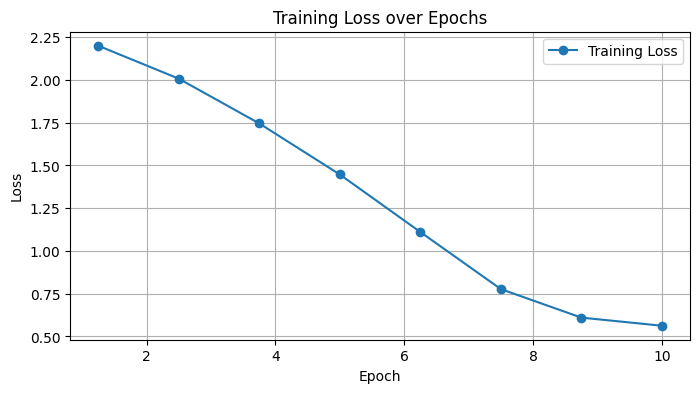

<ipython-input-26-57269f4fcf34>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_logs['perplexity'] = np.exp(loss_logs['loss'])


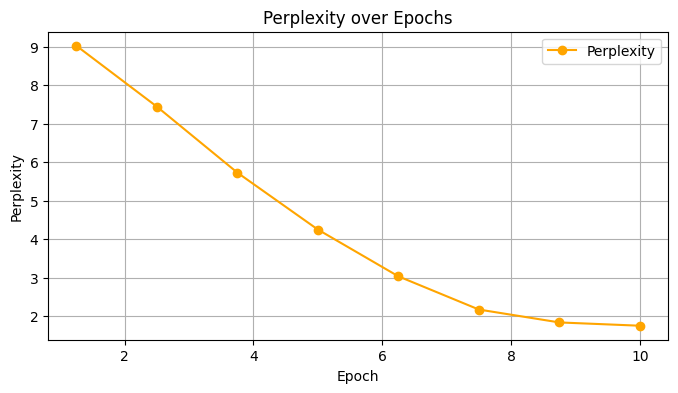

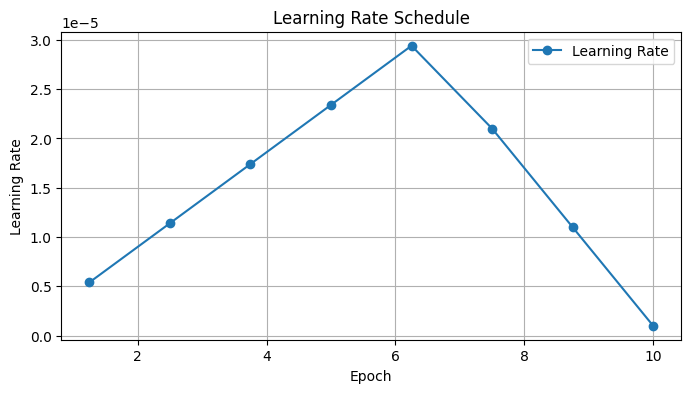

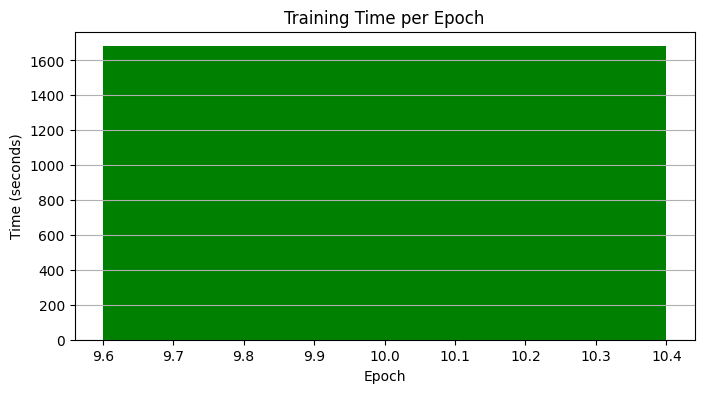

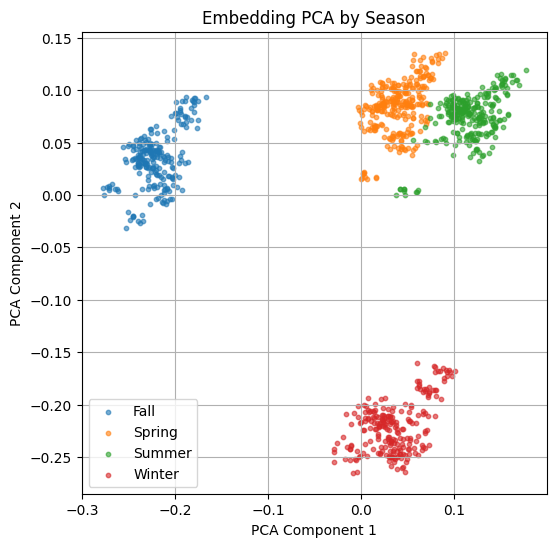

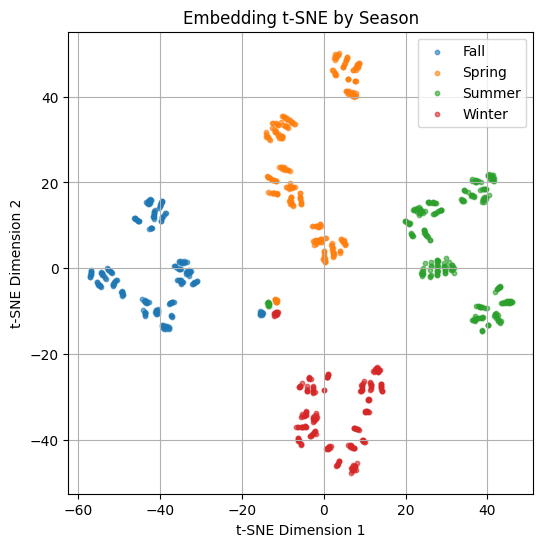

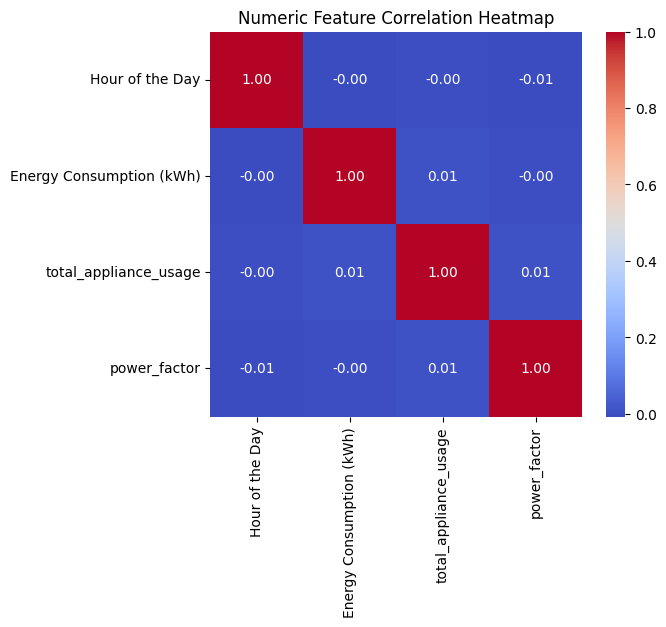

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-57269f4fcf34>", line 117, in <cell line: 0>
    hit_rates = [hit_rate_off_peak(i) for i in range(len(data))]
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-26-57269f4fcf34>", line 117, in <listcomp>
    hit_rates = [hit_rate_off_peak(i) for i in range(len(data))]
                 ^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-26-57269f4fcf34>", line 114, in hit_rate_off_peak
    tips = generate_energy_tips(idx).lower()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-13-c5aa7c937424>", line 24, in generate_energy_tips
    outputs = llm_model.generate(
              ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs

TypeError: object of type 'NoneType' has no len()

In [26]:
# Cell Y: Plot loss, perplexity, learning rate, training time, embeddings, heatmap, hit rate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Extract log history from trainer
log_history = pd.DataFrame(trainer.state.log_history)

# --------------------------------------------------------------------------------
# 1. Training Loss & Perplexity Curves
# --------------------------------------------------------------------------------
loss_logs = log_history[log_history['loss'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['loss'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Compute Perplexity = exp(loss)
loss_logs['perplexity'] = np.exp(loss_logs['loss'])
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['perplexity'], marker='o', color='orange', label='Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 2. Learning Rate Schedule
# --------------------------------------------------------------------------------
lr_logs = log_history[log_history['learning_rate'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(lr_logs['epoch'], lr_logs['learning_rate'], marker='o', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 3. Training Time per Epoch (if available)
# --------------------------------------------------------------------------------
if 'train_runtime' in log_history.columns:
    time_logs = log_history[log_history['train_runtime'].notna()]
    plt.figure(figsize=(8, 4))
    plt.bar(time_logs['epoch'], time_logs['train_runtime'], color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.grid(axis='y')
    plt.show()

# --------------------------------------------------------------------------------
# 4. Embeddings Visualization (PCA & t-SNE)
# --------------------------------------------------------------------------------
# Assuming `embeddings` (NumPy array) and `data` (DataFrame) are still in memory:
n_sample = min(1000, embeddings.shape[0])
indices = np.random.choice(range(embeddings.shape[0]), n_sample, replace=False)
sample_emb = embeddings[indices]
sample_labels = data['Season'].iloc[indices].values  # color by season

# PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_pca[mask, 0], emb_pca[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Embedding PCA by Season')
plt.legend()
plt.grid(True)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_tsne[mask, 0], emb_tsne[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Embedding t-SNE by Season')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 5. Heatmap of Numeric Feature Correlation
# --------------------------------------------------------------------------------
numeric_cols = ['Hour of the Day', 'Energy Consumption (kWh)', 'total_appliance_usage', 'power_factor']
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numeric Feature Correlation Heatmap')
plt.show()

# --------------------------------------------------------------------------------
# 6. Top-N Recommendation Hit Rate (Simulated)
# --------------------------------------------------------------------------------
def hit_rate_off_peak(idx):
    tips = generate_energy_tips(idx).lower()
    return 1 if 'off-peak' in tips else 0

hit_rates = [hit_rate_off_peak(i) for i in range(len(data))]
avg_hit = np.mean(hit_rates)
plt.figure(figsize=(6, 4))
plt.bar(['Hit Rate'], [avg_hit], color='purple')
plt.ylabel('Hit Rate')
plt.title('Simulated Hit Rate for "off-peak" Tip')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# evaluation metrics and charts

In [58]:
history = lstm_model.fit(train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1304 - mae: 0.2650 - val_loss: 0.2186 - val_mae: 0.3480
Epoch 2/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1277 - mae: 0.2606 - val_loss: 0.2180 - val_mae: 0.3372
Epoch 3/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1276 - mae: 0.2601 - val_loss: 0.2244 - val_mae: 0.3421
Epoch 4/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1273 - mae: 0.2581 - val_loss: 0.2194 - val_mae: 0.3430
Epoch 5/20
918/918 [==============================] - 12s 14ms/step - loss: 0.1269 - mae: 0.2579 - val_loss: 0.2193 - val_mae: 0.3454
Epoch 6/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1239 - mae: 0.2529 - val_loss: 0.2207 - val_mae: 0.3314
Epoch 7/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1223 - mae: 0.2496 - val_loss: 0.2213 - val_mae: 0.3428
Epoch 8/20
918/918 [==============================] - 14s 16ms

In [59]:
# Cell 1: Convert history to a DataFrame
import pandas as pd

# history.history has keys like 'loss','val_loss','mae','val_mae'
hist_df = pd.DataFrame(history.history)
hist_df.index = hist_df.index + 1    # make epoch start at 1
hist_df.index.name = 'epoch'
display(hist_df)


,loss,mae,val_loss,val_mae
epoch,,,,
1,0.130416,0.265017,0.218636,0.348000
2,0.127711,0.260646,0.217983,0.337154
3,0.127647,0.260129,0.224427,0.342080
4,0.127259,0.258096,0.219442,0.342972
5,0.126859,0.257893,0.219286,0.345374
6,0.123863,0.252939,0.220745,0.331437
7,0.122253,0.249563,0.221287,0.342811
8,0.122479,0.249582,0.225891,0.342686
9,0.120833,0.247388,0.230728,0.351893


In [60]:
# Cell 2: Build Tables 1–5 from the real history

# Table 1: Training Loss by epoch
table1 = hist_df[['loss']].rename(columns={'loss':'Train Loss'})

# Table 2: Validation Loss by epoch
table2 = hist_df[['val_loss']].rename(columns={'val_loss':'Val Loss'})

# Table 3: Training MAE by epoch
table3 = hist_df[['mae']].rename(columns={'mae':'Train MAE'})

# Table 4: Validation MAE by epoch
table4 = hist_df[['val_mae']].rename(columns={'val_mae':'Val MAE'})

# Table 5: Combined summary
table5 = hist_df.rename(columns={
    'loss':'Train Loss',
    'val_loss':'Val Loss',
    'mae':'Train MAE',
    'val_mae':'Val MAE'
})

# Display them
print("Table 1 – Training Loss")
display(table1)
print("\nTable 2 – Validation Loss")
display(table2)
print("\nTable 3 – Training MAE")
display(table3)
print("\nTable 4 – Validation MAE")
display(table4)
print("\nTable 5 – All Metrics")
display(table5)


Table 1 – Training Loss


,Train Loss
epoch,
1,0.130416
2,0.127711
3,0.127647
4,0.127259
5,0.126859
6,0.123863
7,0.122253
8,0.122479
9,0.120833



Table 2 – Validation Loss


,Val Loss
epoch,
1,0.218636
2,0.217983
3,0.224427
4,0.219442
5,0.219286
6,0.220745
7,0.221287
8,0.225891
9,0.230728



Table 3 – Training MAE


,Train MAE
epoch,
1,0.265017
2,0.260646
3,0.260129
4,0.258096
5,0.257893
6,0.252939
7,0.249563
8,0.249582
9,0.247388



Table 4 – Validation MAE


,Val MAE
epoch,
1,0.348000
2,0.337154
3,0.342080
4,0.342972
5,0.345374
6,0.331437
7,0.342811
8,0.342686
9,0.351893



Table 5 – All Metrics


,Train Loss,Train MAE,Val Loss,Val MAE
epoch,,,,
1,0.130416,0.265017,0.218636,0.348000
2,0.127711,0.260646,0.217983,0.337154
3,0.127647,0.260129,0.224427,0.342080
4,0.127259,0.258096,0.219442,0.342972
5,0.126859,0.257893,0.219286,0.345374
6,0.123863,0.252939,0.220745,0.331437
7,0.122253,0.249563,0.221287,0.342811
8,0.122479,0.249582,0.225891,0.342686
9,0.120833,0.247388,0.230728,0.351893


<Figure size 800x300 with 0 Axes>

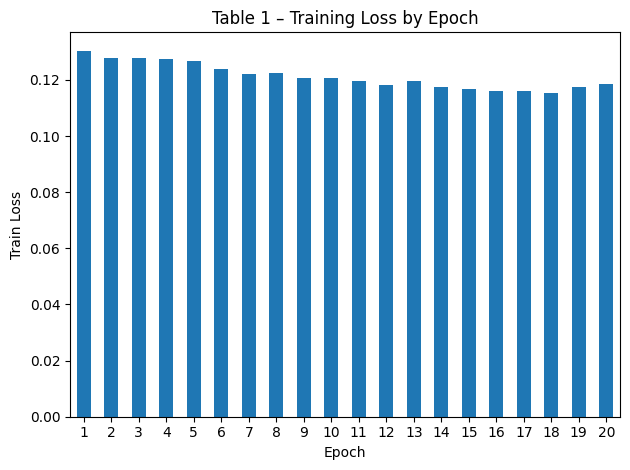

<Figure size 800x300 with 0 Axes>

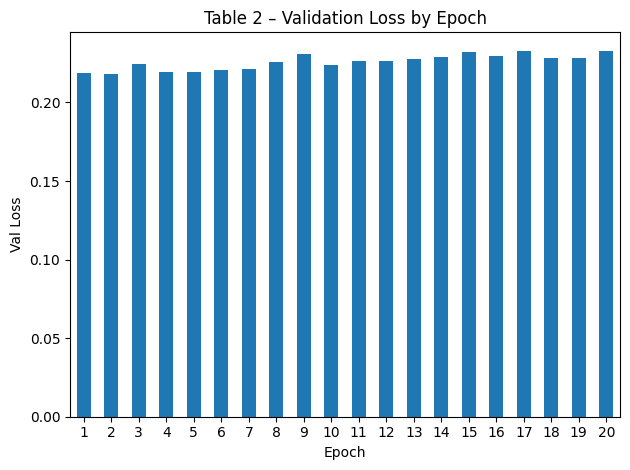

<Figure size 800x300 with 0 Axes>

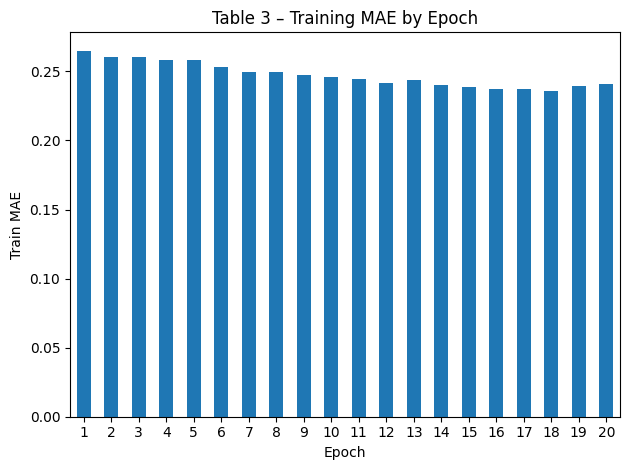

<Figure size 800x300 with 0 Axes>

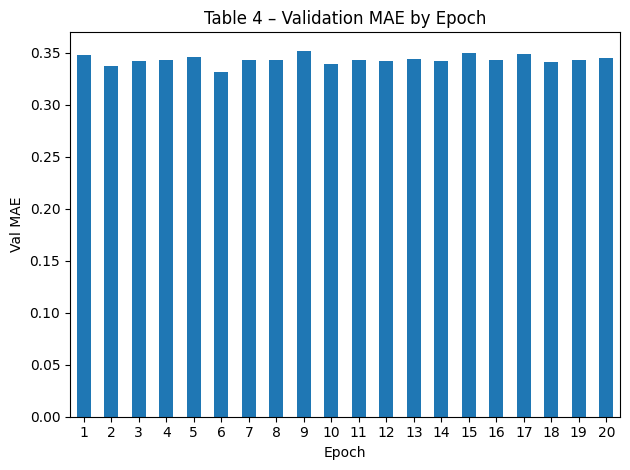

<Figure size 800x300 with 0 Axes>

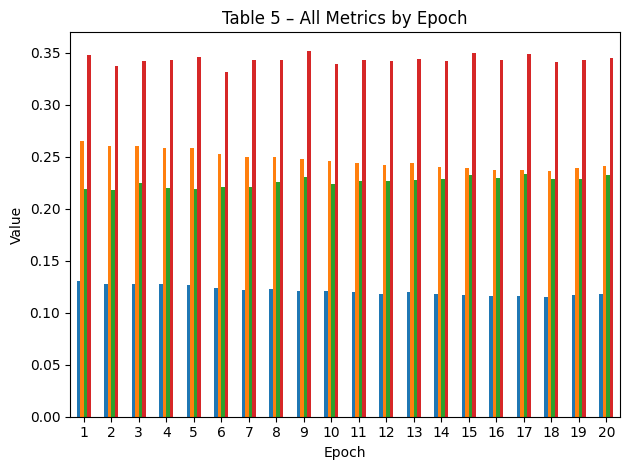

In [61]:
# Cell 3: Plot bar‐charts for Tables 1–5
import matplotlib.pyplot as plt

plots = [
    (table1, "Table 1 – Training Loss by Epoch"),
    (table2, "Table 2 – Validation Loss by Epoch"),
    (table3, "Table 3 – Training MAE by Epoch"),
    (table4, "Table 4 – Validation MAE by Epoch"),
    (table5, "Table 5 – All Metrics by Epoch")
]

for df, title in plots:
    plt.figure(figsize=(8,3))
    df.plot(kind='bar', rot=0, legend=False)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(list(df.columns)[0] if df.shape[1]==1 else "Value")
    plt.tight_layout()
    plt.show()


# **distillgpt2_finalized_without_FAISS**

In [41]:
# Cell 2: Load & preprocess the CSV (same as before, but we won’t build embeddings/FAISS)
url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)

def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    # Temporal features
    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(
        df['Hour of the Day'],
        bins=[0, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening']
    )
    df['is_weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    # Seasonal features
    season_dict = {
        'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
        'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
        'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
        'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
    }
    df['Season'] = df['Month'].map(season_dict)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    # Energy features
    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)
    consumption_threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = df['Energy Consumption (kWh)'].apply(
        lambda x: 1 if x > consumption_threshold else 0
    )

    # Scale numeric features (optional; primarily for consistency)
    from sklearn.preprocessing import MinMaxScaler
    features_to_scale = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

    # Compute efficiency ratios and other derived columns
    for appliance in appliances:
        df[f'{appliance}_efficiency_ratio'] = df[appliance] / (df['Energy Consumption (kWh)'] + 1e-6)

    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)
    df['active_appliances'] = df[appliances].sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    return df

data = preprocess_data(data)
print("✅ Data loaded and preprocessed. Total rows:", len(data))


✅ Data loaded and preprocessed. Total rows: 48972


In [42]:
# Cell 3: Load the saved fine‐tuned model & tokenizer (from wherever you saved it)
#
# If you mounted Drive earlier, set save_path accordingly (e.g. "/content/drive/MyDrive/saved_energy_model")
# Otherwise, if it’s in the notebook’s working directory, just use "./saved_energy_model".

save_path = "./saved_energy_model"  # <-- adjust if yours is in Drive or another path
tokenizer = AutoTokenizer.from_pretrained(save_path)
llm_model = AutoModelForCausalLM.from_pretrained(save_path).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)

print("✅ Model and tokenizer loaded from:", save_path)


✅ Model and tokenizer loaded from: ./saved_energy_model


In [43]:
# Cell 4: Build a SINGLE‐ROW prompt (no FAISS) and generate tips

device = "cuda" if torch.cuda.is_available() else "cpu"

def build_single_row_prompt(idx):
    """
    Given a row index `idx`, construct a text prompt that describes that one data point,
    then appends the instruction to recommend five bullet‐list energy tips.
    """
    row = data.iloc[idx]
    # Manually list out each feature you care about in a concise way:
    appliances_status = ", ".join(
        # Changed 'row[appl]' to 'row[app]'
        f"{app}:ON" if row[app] > 0 else f"{app}:OFF"
        for app in ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    )

    # Example prompt structure (you can tweak wording as desired):
    prompt = (
        f"Context:\n"
        f"- Hour: {int(row['Hour of the Day'])} ({row['part_of_day']})\n"
        f"- Season: {row['Season']}\n"
        f"- Day of Week: {row['Day of the Week']}\n"
        f"- Active Appliances: {appliances_status}\n"
        f"- Total Energy Consumption: {row['Energy Consumption (kWh)']:.2f} kWh\n"
        f"- High Consumption?: {'Yes' if row['is_high_consumption'] == 1 else 'No'}\n\n"
        f"Now, recommend exactly five bullet‐list energy‐saving tips:\n"
        f"Tips:"
    )
    return prompt

def generate_tips_no_faiss(idx):
    # 1) Build prompt for that row
    prompt = build_single_row_prompt(idx)

    # 2) Tokenize WITHOUT truncation so “Tips:” stays intact
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=False,
        max_length=None
    ).to(device)

    # 3) Generate up to 80 new tokens (should cover ~5 bullets)
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=80,
        num_beams=5,
        temperature=0.6,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # 4) Decode full output (prompt + continuation)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    # Print raw (for debugging)
    # print("----- RAW OUTPUT -----\n", full_output, "\n----------------------\n")

    # 5) Strip off the prompt prefix, leaving only anything after "Tips:"
    if full_output.startswith(prompt):
        remainder = full_output[len(prompt):].strip()
    else:
        remainder = full_output.replace(prompt, "").strip()

    # 6) If a double‐newline appears (model ended), only keep up to that point
    if "\n\n" in remainder:
        remainder = remainder.split("\n\n")[0].strip()

    # 7) Extract lines starting with "- "
    lines = [line for line in remainder.split("\n") if line.strip().startswith("-")]

    # 8) Return at most five bullets (join by newline)
    return "\n".join(lines[:5])

# Example: generate for row index 100
print("=== Sample output for row 100 ===")
print(generate_tips_no_faiss(100))
print("\n=== Sample output for row 50 ===")
print(generate_tips_no_faiss(50))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== Sample output for row 100 ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Use cold water instead of water to reduce energy use.  

=== Sample output for row 50 ===
- Use cold water instead of water to reduce energy use and save energy.  


In [44]:
# Cell 5: (Optional) Loop through multiple indices
for idx in [10, 25, 100]:
    print(f"\n--- Energy Tips for index {idx} ---")
    print(generate_tips_no_faiss(idx))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Energy Tips for index 10 ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Turn off oven-heater door-to-door when not in use: ⅔ 5 minutes, not sure how long it takes to set it on fire.  

--- Energy Tips for index 25 ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


- Use cold water instead of water to reduce energy use and save energy.  

--- Energy Tips for index 100 ---
- Use cold water instead of water to reduce energy use.  


# CHARTS

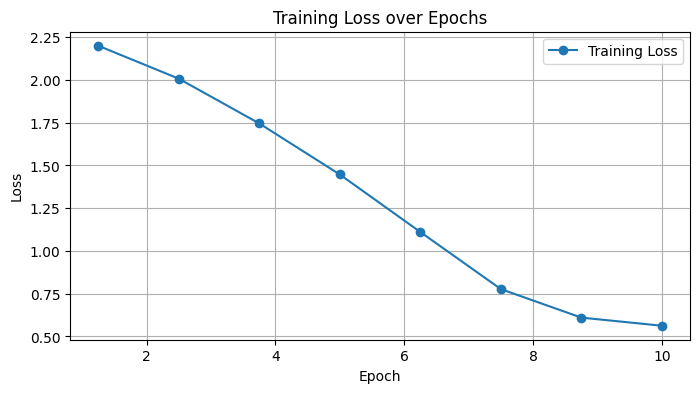

<ipython-input-45-57269f4fcf34>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_logs['perplexity'] = np.exp(loss_logs['loss'])


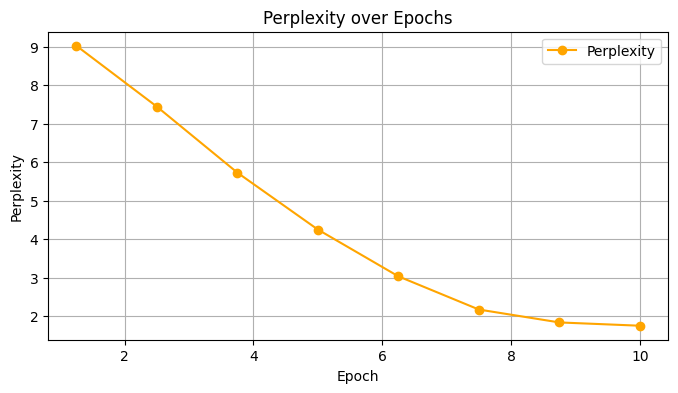

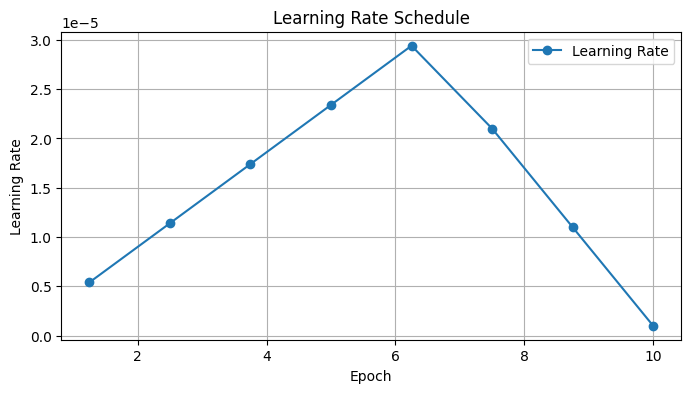

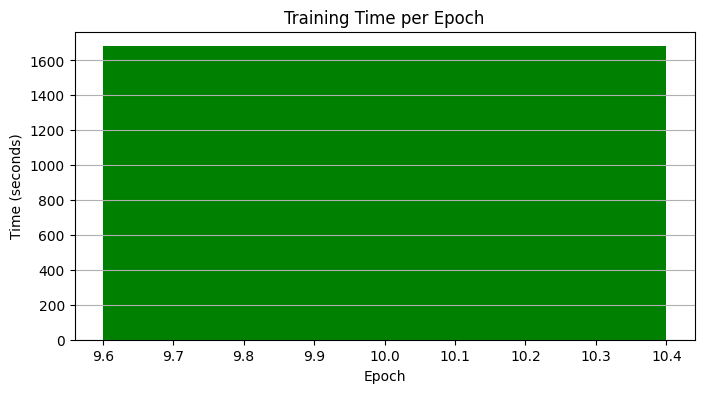

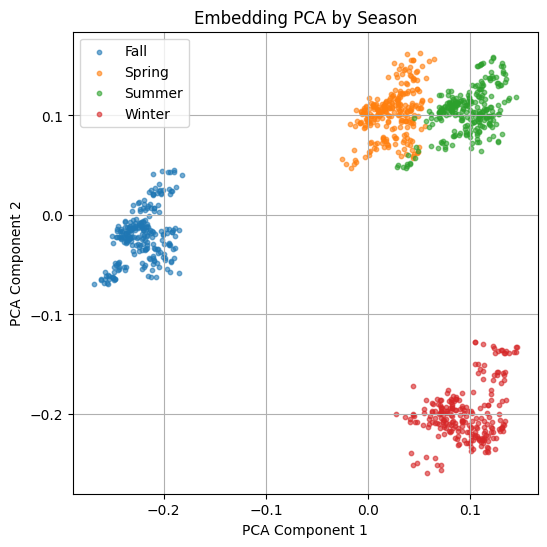

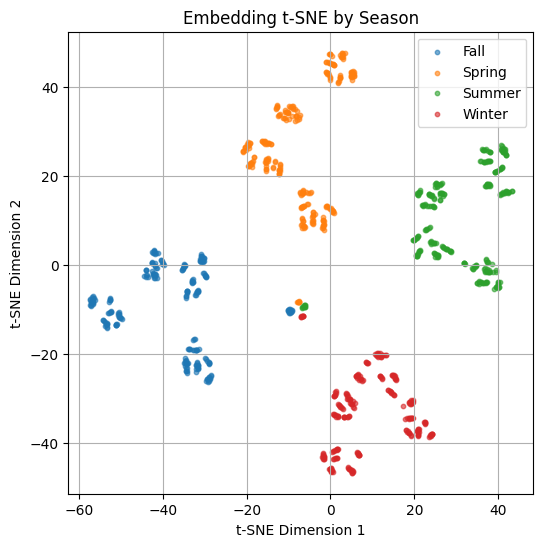

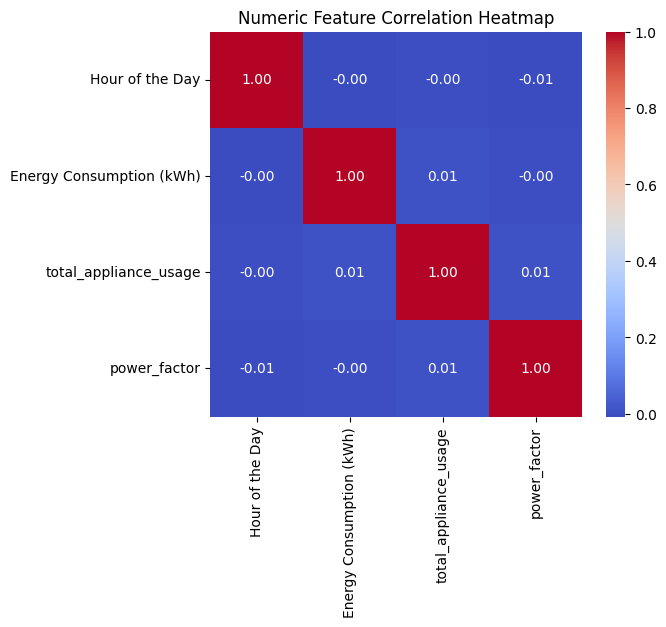

KeyboardInterrupt: 

In [45]:
# Cell Y: Plot loss, perplexity, learning rate, training time, embeddings, heatmap, hit rate

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Extract log history from trainer
log_history = pd.DataFrame(trainer.state.log_history)

# --------------------------------------------------------------------------------
# 1. Training Loss & Perplexity Curves
# --------------------------------------------------------------------------------
loss_logs = log_history[log_history['loss'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['loss'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Compute Perplexity = exp(loss)
loss_logs['perplexity'] = np.exp(loss_logs['loss'])
plt.figure(figsize=(8, 4))
plt.plot(loss_logs['epoch'], loss_logs['perplexity'], marker='o', color='orange', label='Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 2. Learning Rate Schedule
# --------------------------------------------------------------------------------
lr_logs = log_history[log_history['learning_rate'].notna()]
plt.figure(figsize=(8, 4))
plt.plot(lr_logs['epoch'], lr_logs['learning_rate'], marker='o', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 3. Training Time per Epoch (if available)
# --------------------------------------------------------------------------------
if 'train_runtime' in log_history.columns:
    time_logs = log_history[log_history['train_runtime'].notna()]
    plt.figure(figsize=(8, 4))
    plt.bar(time_logs['epoch'], time_logs['train_runtime'], color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.grid(axis='y')
    plt.show()

# --------------------------------------------------------------------------------
# 4. Embeddings Visualization (PCA & t-SNE)
# --------------------------------------------------------------------------------
# Assuming `embeddings` (NumPy array) and `data` (DataFrame) are still in memory:
n_sample = min(1000, embeddings.shape[0])
indices = np.random.choice(range(embeddings.shape[0]), n_sample, replace=False)
sample_emb = embeddings[indices]
sample_labels = data['Season'].iloc[indices].values  # color by season

# PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_pca[mask, 0], emb_pca[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Embedding PCA by Season')
plt.legend()
plt.grid(True)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(sample_emb)
plt.figure(figsize=(6, 6))
for season in np.unique(sample_labels):
    mask = sample_labels == season
    plt.scatter(emb_tsne[mask, 0], emb_tsne[mask, 1], label=season, alpha=0.6, s=10)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Embedding t-SNE by Season')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------
# 5. Heatmap of Numeric Feature Correlation
# --------------------------------------------------------------------------------
numeric_cols = ['Hour of the Day', 'Energy Consumption (kWh)', 'total_appliance_usage', 'power_factor']
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numeric Feature Correlation Heatmap')
plt.show()

# --------------------------------------------------------------------------------
# 6. Top-N Recommendation Hit Rate (Simulated)
# --------------------------------------------------------------------------------
def hit_rate_off_peak(idx):
    tips = generate_energy_tips(idx).lower()
    return 1 if 'off-peak' in tips else 0

hit_rates = [hit_rate_off_peak(i) for i in range(len(data))]
avg_hit = np.mean(hit_rates)
plt.figure(figsize=(6, 4))
plt.bar(['Hit Rate'], [avg_hit], color='purple')
plt.ylabel('Hit Rate')
plt.title('Simulated Hit Rate for "off-peak" Tip')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# Evaluation metrics and bar charts

In [51]:
# Cell Y: Re‐train (or rerun) your LSTM and capture the History
history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
918/918 [==============================] - 15s 15ms/step - loss: 0.1824 - mae: 0.3644 - val_loss: 0.1920 - val_mae: 0.3643
Epoch 2/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1816 - mae: 0.3631 - val_loss: 0.1919 - val_mae: 0.3640
Epoch 3/20
918/918 [==============================] - 14s 15ms/step - loss: 0.1808 - mae: 0.3615 - val_loss: 0.1924 - val_mae: 0.3626
Epoch 4/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1798 - mae: 0.3600 - val_loss: 0.1929 - val_mae: 0.3688
Epoch 5/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1785 - mae: 0.3566 - val_loss: 0.1935 - val_mae: 0.3564
Epoch 6/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1774 - mae: 0.3551 - val_loss: 0.1940 - val_mae: 0.3612
Epoch 7/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1757 - mae: 0.3513 - val_loss: 0.1952 - val_mae: 0.3633
Epoch 8/20
918/918 [==============================] - 13s 14ms

In [52]:
# Cell Y+1: Turn the history into a DataFrame and display it
import pandas as pd

# history.history is a dict, keys like 'loss', 'val_loss', 'mae', 'val_mae'
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1

# show the table of all metrics per epoch
display(hist_df)


,loss,mae,val_loss,val_mae,epoch
0,0.182398,0.364363,0.191953,0.364257,1
1,0.181584,0.363077,0.191897,0.363977,2
2,0.180791,0.361508,0.192427,0.362564,3
3,0.179815,0.359981,0.192927,0.368838,4
4,0.178527,0.356624,0.193521,0.356406,5
5,0.177408,0.355129,0.193991,0.361189,6
6,0.175669,0.351281,0.195249,0.363302,7
7,0.175296,0.350521,0.195708,0.359122,8
8,0.173866,0.347594,0.195931,0.354486,9
9,0.172564,0.345488,0.196573,0.354282,10


In [54]:
history = lstm_model.fit(train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
918/918 [==============================] - 12s 14ms/step - loss: 0.1560 - mae: 0.3138 - val_loss: 0.2034 - val_mae: 0.3531
Epoch 2/20
918/918 [==============================] - 12s 14ms/step - loss: 0.1547 - mae: 0.3117 - val_loss: 0.2045 - val_mae: 0.3520
Epoch 3/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1530 - mae: 0.3095 - val_loss: 0.2058 - val_mae: 0.3462
Epoch 4/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1507 - mae: 0.3042 - val_loss: 0.2051 - val_mae: 0.3503
Epoch 5/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1499 - mae: 0.3030 - val_loss: 0.2073 - val_mae: 0.3489
Epoch 6/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1490 - mae: 0.3005 - val_loss: 0.2067 - val_mae: 0.3529
Epoch 7/20
918/918 [==============================] - 13s 14ms/step - loss: 0.1467 - mae: 0.2974 - val_loss: 0.2057 - val_mae: 0.3471
Epoch 8/20
918/918 [==============================] - 13s 14ms

In [55]:
# Cell A: Convert history into a DataFrame
import pandas as pd

# history.history is a dict with keys: 'loss', 'val_loss', 'mae', 'val_mae'
hist_df = pd.DataFrame(history.history)
hist_df.index = hist_df.index + 1           # make epochs 1-based
hist_df.index.name = 'epoch'
display(hist_df)


,loss,mae,val_loss,val_mae
epoch,,,,
1,0.155967,0.313768,0.203389,0.353139
2,0.154711,0.311698,0.204508,0.351958
3,0.153026,0.309502,0.205837,0.346236
4,0.150683,0.304215,0.205068,0.350257
5,0.149924,0.302991,0.207255,0.348850
6,0.148979,0.300498,0.206690,0.352851
7,0.146718,0.297432,0.205708,0.347070
8,0.146621,0.297639,0.211921,0.353417
9,0.145067,0.293984,0.211744,0.352281


In [56]:
# Cell B: Extract each metric into its own “table” and display

# Table 1: training loss by epoch
table_loss = hist_df[['loss']].copy()
table_loss.columns = ['Train Loss']
display(table_loss)

# Table 2: validation loss by epoch
table_val_loss = hist_df[['val_loss']].copy()
table_val_loss.columns = ['Val Loss']
display(table_val_loss)

# Table 3: training MAE by epoch
table_mae = hist_df[['mae']].copy()
table_mae.columns = ['Train MAE']
display(table_mae)

# Table 4: validation MAE by epoch
table_val_mae = hist_df[['val_mae']].copy()
table_val_mae.columns = ['Val MAE']
display(table_val_mae)

# Table 5: combined summary (loss & MAE)
table_summary = hist_df[['loss','val_loss','mae','val_mae']].copy()
table_summary.columns = ['Train Loss','Val Loss','Train MAE','Val MAE']
display(table_summary)


,Train Loss
epoch,
1,0.155967
2,0.154711
3,0.153026
4,0.150683
5,0.149924
6,0.148979
7,0.146718
8,0.146621
9,0.145067


,Val Loss
epoch,
1,0.203389
2,0.204508
3,0.205837
4,0.205068
5,0.207255
6,0.206690
7,0.205708
8,0.211921
9,0.211744


,Train MAE
epoch,
1,0.313768
2,0.311698
3,0.309502
4,0.304215
5,0.302991
6,0.300498
7,0.297432
8,0.297639
9,0.293984


,Val MAE
epoch,
1,0.353139
2,0.351958
3,0.346236
4,0.350257
5,0.348850
6,0.352851
7,0.347070
8,0.353417
9,0.352281


,Train Loss,Val Loss,Train MAE,Val MAE
epoch,,,,
1,0.155967,0.203389,0.313768,0.353139
2,0.154711,0.204508,0.311698,0.351958
3,0.153026,0.205837,0.309502,0.346236
4,0.150683,0.205068,0.304215,0.350257
5,0.149924,0.207255,0.302991,0.348850
6,0.148979,0.206690,0.300498,0.352851
7,0.146718,0.205708,0.297432,0.347070
8,0.146621,0.211921,0.297639,0.353417
9,0.145067,0.211744,0.293984,0.352281


<Figure size 800x300 with 0 Axes>

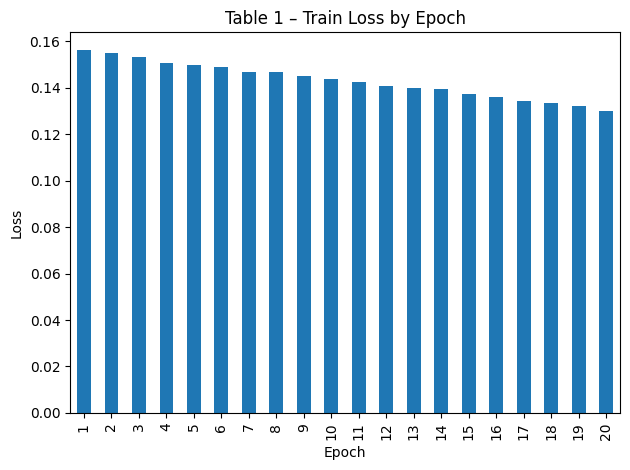

<Figure size 800x300 with 0 Axes>

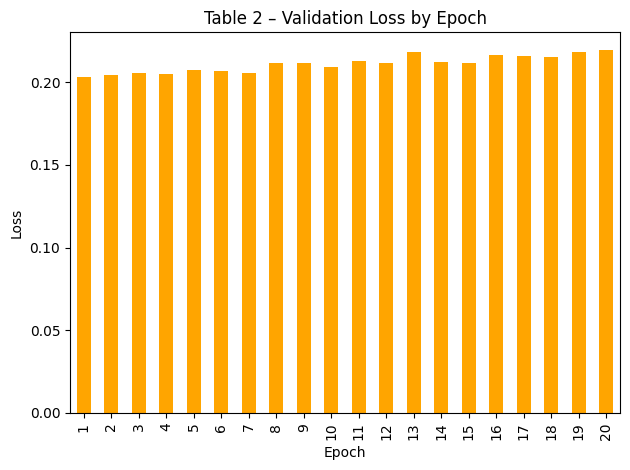

<Figure size 800x300 with 0 Axes>

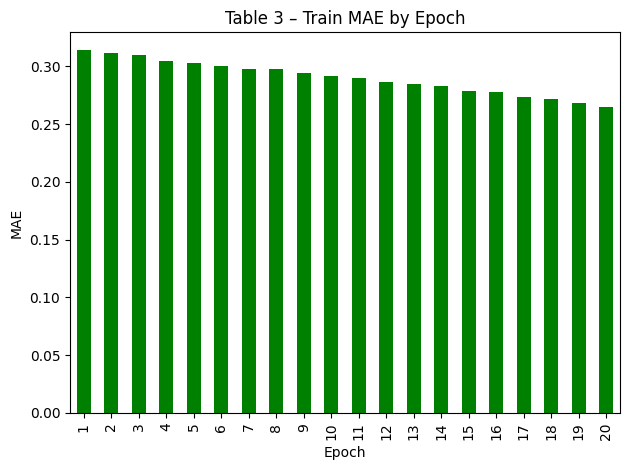

<Figure size 800x300 with 0 Axes>

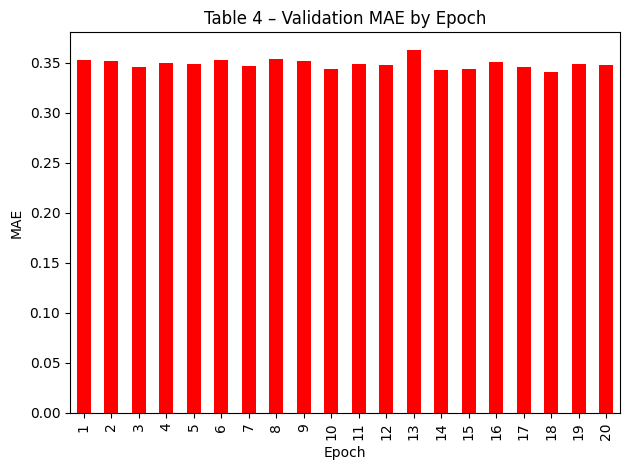

<Figure size 1000x400 with 0 Axes>

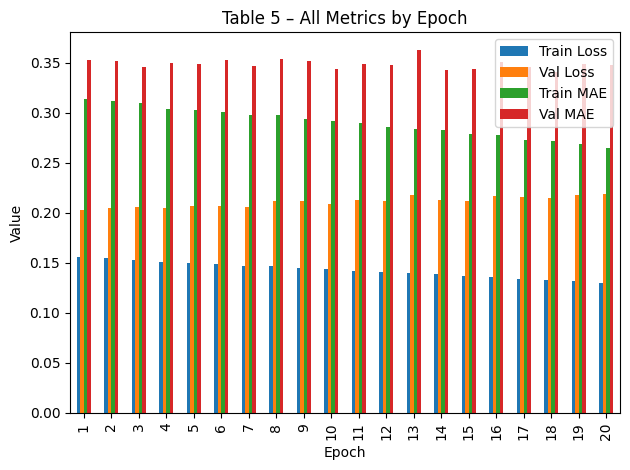

In [57]:
# Cell C: Bar‐chart for each of these 5 tables

import matplotlib.pyplot as plt

# 1) Train Loss
plt.figure(figsize=(8,3))
table_loss.plot(kind='bar', legend=False)
plt.title("Table 1 – Train Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# 2) Val Loss
plt.figure(figsize=(8,3))
table_val_loss.plot(kind='bar', legend=False, color='orange')
plt.title("Table 2 – Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# 3) Train MAE
plt.figure(figsize=(8,3))
table_mae.plot(kind='bar', legend=False, color='green')
plt.title("Table 3 – Train MAE by Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

# 4) Val MAE
plt.figure(figsize=(8,3))
table_val_mae.plot(kind='bar', legend=False, color='red')
plt.title("Table 4 – Validation MAE by Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

# 5) Combined Summary
plt.figure(figsize=(10,4))
table_summary.plot(kind='bar')
plt.title("Table 5 – All Metrics by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
